# 니켈 가격 예측 모델 비교 분석

**분석 흐름**
1. 데이터 전처리 및 SHAP 기반 피처 선택
2. 베이스라인 모델 5종 비교 → 최적 모델 선정
3. 최적 베이스라인 기반 Residual 스태킹 → 상위 2개 조합 선정
4. 상위 Residual 조합 기반 ROR 스태킹 → 최종 모델 선정
5. 백테스트 및 성능 평가


## 0. Experiment Design
목표: 누수 없는 평가와 공정한 모델 비교.
- y는 **니켈 가격 레벨**로 고정
- x는 **1주 지연된 가격 레벨 피처** (누수 방지)
- Split 고정:
  - Train: 2025-08-04 이전
  - Validation: 2025-08-04 ~ 2025-10-20
  - Test: 2025-10-27 ~ 2026-01-12
- 모델 선택/튜닝은 Validation에서만, Test는 최종 평가용



## 0.1 실험 설계

### 3단계 스태킹 구조

| 단계 | 설명 | 목표 |
|------|------|------|
| **Stage 1 (Baseline)** | 원본 피처 → 가격 예측 | 기준선 확립 |
| **Stage 2 (Residual)** | 잔차 = 실제 - Baseline 예측 → 잔차 보정 | 오차 축소 |
| **Stage 3 (ROR)** | 최종 미세 보정 | 성능 극대화 |

### 사용 모델

| 모델 | 특성 |
|------|------|
| GradientBoosting | 안정적, 해석 가능 |
| XGBoost | 빠른 학습, 강한 비선형 |
| LightGBM | 대용량 처리, 빠름 |
| CatBoost | 과적합 억제 |
| AdaBoost | 약한 학습기 조합 |

### 실험 전략

**단계별 탈락 방식 (Stage-wise Pruning)**
1. 베이스라인 5개 모델 전체 비교 → 최적 모델 선정
2. 최적 베이스라인 기반 Residual 조합 탐색 → 상위 2개 선정
3. 상위 2개 조합으로 ROR 확장 → 최종 모델 선정

이 방식으로 실험 수를 줄이면서 체계적으로 최적 조합을 탐색.


In [27]:
# 0. 환경 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# ============================================================
#  CONFIG: 모든 설정값을 여기서 관리
# ============================================================

CONFIG = {
    # 데이터 설정
    'data_file': 'data_weekly_260120.csv',
    'target_col': 'Com_LME_Ni_Cash',
    
    # 기간 설정 (교수님 지정)
    'val_start': '2025-08-04',
    'val_end': '2025-10-20',
    'test_start': '2025-10-27',
    'test_end': '2026-01-12',
    
    # 피처 선택
    'top_n_features': 20,
    'exclude_lme_index': True,  # 파생피처 제외 여부
    
    # 모델 설정
    'random_seed': 42,
    'n_estimators_default': 500,
    'learning_rate_default': 0.05,
    
    # 백테스트 설정
    'trading_thresholds': [0.003, 0.005, 0.01],
    'transaction_cost': 0.001,  # 0.1% 거래비용 
    'slippage': 0.0005,  # 0.05% 슬리피지
    
    # ROR 설정
    'ror_target_mode': 'pred_minus_residual',
    
    # 하이퍼파라미터 튜닝
    'tuning_budget': {
        'XGBoost': 16,
        'LightGBM': 16,
        'CatBoost': 12,
        'GradientBoosting': 10,
        'AdaBoost': 10
    }
}

# 설정 출력
print("=" * 60)
print(" Project Configuration")
print("=" * 60)
for key, value in CONFIG.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"{key}: {value}")
print("=" * 60)

# Random seed 고정 (재현성)
np.random.seed(CONFIG['random_seed'])

# 출력 폴더 생성
import os
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")


📌 Project Configuration
data_file: data_weekly_260120.csv
target_col: Com_LME_Ni_Cash
val_start: 2025-08-04
val_end: 2025-10-20
test_start: 2025-10-27
test_end: 2026-01-12
top_n_features: 20
exclude_lme_index: True
random_seed: 42
n_estimators_default: 500
learning_rate_default: 0.05
trading_thresholds: [0.003, 0.005, 0.01]
transaction_cost: 0.001
slippage: 0.0005
ror_target_mode: pred_minus_residual
tuning_budget:
  XGBoost: 16
  LightGBM: 16
  CatBoost: 12
  GradientBoosting: 10
  AdaBoost: 10
Output directory: output


## 1. Data Preparation
목표: 니켈 가격(y)을 정의하고 시간순 정렬, 결측 처리, 변환을 수행.
해석: y와 x 모두 **가격 레벨**이며, x는 누수 방지를 위해 **1주 지연**을 적용.



### Feature Engineering 설명 (CatBoost 영향 관점)

아래 전처리 셀에서 수행한 피처 엔지니어링 흐름을 단계별로 정리했습니다. CatBoost 성능에 영향을 줄 수 있는 포인트도 함께 표시했습니다.

1) **컬럼 선택(필터링)**
- 타깃(`Com_LME_Ni_Cash`) + 거시/금융 지표(`Idx_`, `Bonds_`, `EX_`) + 원자재/금속(`Com_LME` 및 금속 이름 포함) 컬럼만 사용합니다.
- 관련성이 낮은 컬럼을 제거해 노이즈를 줄이고 모델이 유의미한 분할을 찾기 쉽게 합니다.

2) **결측 처리**
- `ffill()`로 과거 값으로 채우고, 이후 `dropna()`로 남은 결측을 제거합니다.
- **미래값으로 채우는 누수(backfill)를 의도적으로 피함**.
- CatBoost는 결측을 자체 처리할 수 있지만, `ffill`은 **인위적인 연속성/추세**를 만들 수 있어 분기 규칙에 영향을 줄 수 있습니다.

3) **수익률 변환 (EDA용)**
- 로그 수익률(`log(현재/이전)`)은 **EDA/변동성 분석용**으로만 계산합니다.
- 0/음수 포함 컬럼은 로그가 어려워 **차분(`diff`)은 선택 사항**입니다.
- 로그 수익률/차분은 분포를 안정화할 수 있으나 **현재 모델 피처에는 사용하지 않습니다**.
- 필요 시 실험으로 추가할 수 있습니다.

4) **타깃/피처 분리와 시점 지연(누수 방지)**
- 타깃 `y`는 **가격 레벨**(원시값)로 유지합니다.
- 피처 `X`는 **가격 레벨**에서 `shift(1)` 하여 **1주 지연된 정보만 사용**합니다.
- 즉, `X(t-1) → y(t)` 구조로 **정보 누수 방지**.
- CatBoost는 과적합에 강하지만, **누수 제거는 성능의 신뢰성**을 크게 좌우합니다.

5) **인덱스 정렬**
- `shift`/`diff`로 생긴 NaN을 제거하고, `X`/`y`의 **공통 인덱스만 사용**하여 완전 정렬합니다.
- 학습 샘플 수가 줄어들지만, **정확한 시점 대응**을 보장합니다.

**CatBoost 성능에 영향 가능성 요약**
- 트리 모델은 스케일링에 둔감하지만 **분포 형태(로그/차분)**와 **노이즈 수준**에 민감합니다.
- 가격 레벨 피처는 **추세 정보**를 유지하지만 비정상성(추세/계절성)에 민감할 수 있습니다.
- `ffill`로 생성된 구간은 변동성이 낮아져 **과도한 보수적 분기**로 이어질 수 있습니다.

필요하면 다음을 추가 실험해 볼 수 있습니다(누수 주의):
- 타깃 레벨의 **lag(1~k)** 를 피처로 추가
- **이동평균/변동성(rolling std)** 등 레벨 기반 파생 피처
- 비정상성 완화 목적의 **Box-Cox/Robust 변환** 비교


In [28]:
# 1. 데이터 필터링 및 전처리
filename = "data_weekly_260120.csv"
df_raw = pd.read_csv(filename)
df_raw["dt"] = pd.to_datetime(df_raw["dt"])
df_raw = df_raw.set_index("dt").sort_index()

def filter_cols(columns):
    target = "Com_LME_Ni_Cash"
    metals = ["Gold", "Silver", "Iron", "Steel", "Copper", "Aluminum", "Zinc", "Nickel", "Lead", "Tin", "Uranium"]
    filtered = [target]
    for col in columns:
        if any(x in col for x in ["Idx_", "Bonds_", "EX_"]):
            filtered.append(col)
        elif "Com_LME" in col:
            filtered.append(col)
        elif any(m in col for m in metals):
            filtered.append(col)
    return sorted(list(set(filtered)))

filtered_cols = filter_cols(df_raw.columns)
df = df_raw[filtered_cols].copy()
df = df.ffill().bfill()

# 로그 수익률 (EDA용)
df_ret = np.log(df / df.shift(1))

# --- 누수 방지: 1주 지연 피처 ---
target_col = "Com_LME_Ni_Cash"
price_full = df[target_col]  # full price series for prev-price calc
y = price_full  # price level target
X = df.drop(columns=[target_col]).shift(1)  # Lag features (price level)

# y와 X 정렬
valid_idx = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_idx]
y = y.loc[valid_idx]

print(f"Feature Count: {X.shape[1]}")
print(f"Total Samples (aligned): {len(y)}")
print("Data leakage prevented: Using X(t-1) to predict y(t)")

Feature Count: 51
Total Samples (aligned): 667
Data leakage prevented: Using X(t-1) to predict y(t)


### 1.1 Data Overview
목표: 가격 추세, 수익률 분포, 변동성 수준을 시각적으로 확인.
해석: 이상치나 변동성 급등은 모델 불안정 신호.


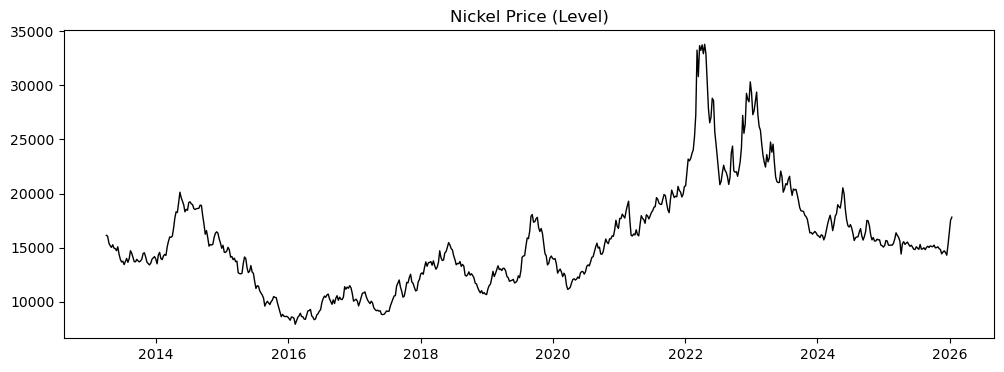

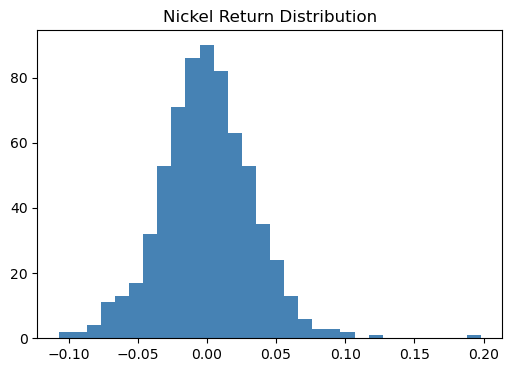

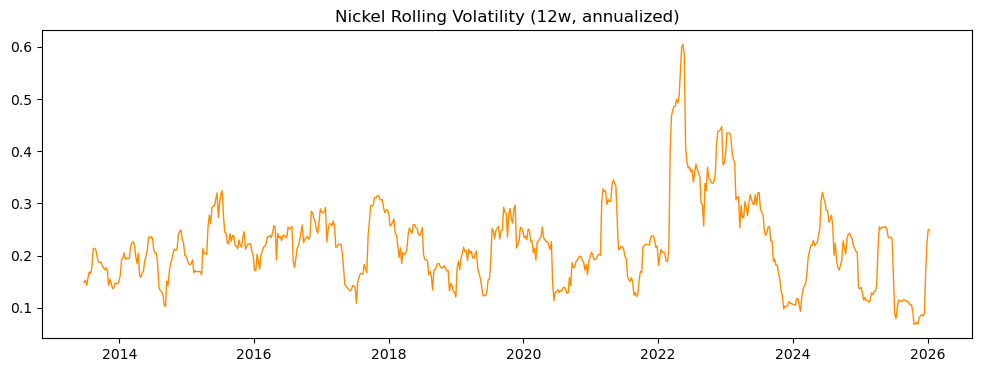

In [29]:
# 1.1 데이터 개요 시각화
plt.figure(figsize=(12, 4))
plt.plot(df.index, df[target_col], color='black', linewidth=1)
plt.title('Nickel Price (Level)')
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_ret[target_col].dropna(), bins=30, color='steelblue')
plt.title('Nickel Return Distribution')
plt.show()

rolling_vol = df_ret[target_col].rolling(12).std() * np.sqrt(52)
plt.figure(figsize=(12, 4))
plt.plot(rolling_vol.index, rolling_vol, color='darkorange', linewidth=1)
plt.title('Nickel Rolling Volatility (12w, annualized)')
plt.show()



## 2. 데이터 품질 검사s
목표: 주간 주기(7일)와 결측 여부를 확인.
해석: 주기가 깨지면 리샘플링 필요, 결측은 재처리 필요.


In [30]:
# 2. 데이터 품질 검사
missing = df.isnull().sum().sum()
if missing > 0:
    print(f"Missing values remain after forward fill: {missing}")
    print("Consider dropping initial rows or imputing within train only.")
else:
    print("Data is clean. No missing values found.")

# 주기 검사
freq_check = df.index.to_series().diff().dt.days.value_counts()
print("\nTime Frequency Distribution (Days):")
print(freq_check)

if freq_check.index[0] != 7:
    print("WARNING: Data is not strictly weekly. Consider resampling if necessary.")
else:
    print("Data confirmed as Weekly.")


Data is clean. No missing values found.

Time Frequency Distribution (Days):
dt
7.0    667
Name: count, dtype: int64
Data confirmed as Weekly.


## 3. Feature Selection (Train-Only)
목표: SHAP 기반으로 니켈에 영향 큰 변수를 선택.
해석: train-only로 선택해 validation/test 정보 누수를 차단.



In [31]:
# 3. 학습/검증/테스트 분할 + SHAP 피처 선택
# CONFIG에서 기간 설정 로드
VAL_START = CONFIG['val_start']
VAL_END = CONFIG['val_end']
TEST_START = CONFIG['test_start']
TEST_END = CONFIG['test_end']
top_n = CONFIG['top_n_features']

# ============================================================
#  기간별 데이터 분할 (고정 날짜)
# ============================================================
X_train_all = X.loc[X.index < VAL_START]
y_train = y.loc[X_train_all.index]

X_val_all = X.loc[(X.index >= VAL_START) & (X.index <= VAL_END)]
y_val = y.loc[X_val_all.index]

X_test_all = X.loc[(X.index >= TEST_START) & (X.index <= TEST_END)]
y_test = y.loc[X_test_all.index]

# 유효성 검사
assert len(X_train_all) > 0, "Train set이 비어있습니다"
assert len(X_val_all) > 0, "Validation set이 비어있습니다"
assert len(X_test_all) > 0, "Test set이 비어있습니다"

print(" 데이터 분할:")
print(f"  Train : {X_train_all.index.min().date()} ~ {X_train_all.index.max().date()} ({len(X_train_all)}주)")
print(f"  Val   : {X_val_all.index.min().date()} ~ {X_val_all.index.max().date()} ({len(X_val_all)}주)")
print(f"  Test  : {X_test_all.index.min().date()} ~ {X_test_all.index.max().date()} ({len(X_test_all)}주)")

# ============================================================
# SHAP 피처 선택 (학습 데이터만 사용)
# ============================================================
print("\n SHAP 피처 선택 중... (Train 데이터만 사용)")

model_shap = xgb.XGBRegressor(
    n_estimators=100, 
    random_state=CONFIG['random_seed'], 
    n_jobs=-1
)
model_shap.fit(X_train_all, y_train)

explainer = shap.TreeExplainer(model_shap)
shap_val = explainer.shap_values(X_train_all)
importances = np.abs(shap_val).mean(axis=0)

feat_imp = pd.DataFrame({
    "feature": X_train_all.columns, 
    "importance": importances
}).sort_values("importance", ascending=False)

# 피처 선택
selected_features = feat_imp.head(top_n)["feature"].tolist()

# CONFIG에 따라 LME Index 제외
if CONFIG['exclude_lme_index']:
    excluded = [f for f in selected_features if 'Com_LME_Index' in f]
    selected_features = [f for f in selected_features if 'Com_LME_Index' not in f]
    
    # 제외된 만큼 다음 순위에서 보충
    remaining = feat_imp[~feat_imp['feature'].isin(selected_features + excluded)]
    remaining = remaining[~remaining['feature'].str.contains('Com_LME_Index')]
    n_to_add = top_n - len(selected_features)
    if n_to_add > 0:
        selected_features.extend(remaining.head(n_to_add)['feature'].tolist())
    
    print(f"\n⚠️ 파생피처 제외됨: {excluded}")

# 선택된 피처로 데이터셋 구성
X_train = X_train_all[selected_features]
X_val = X_val_all[selected_features]
X_test = X_test_all[selected_features]

print(f"\n 선택된 피처 ({len(selected_features)}개):")
for i, f in enumerate(selected_features[:10], 1):
    imp = feat_imp[feat_imp['feature'] == f]['importance'].values[0]
    print(f"  {i:2d}. {f} (SHAP: {imp:.4f})")
if len(selected_features) > 10:
    print(f"  ... 외 {len(selected_features) - 10}개")


📅 데이터 분할:
  Train : 2013-04-08 ~ 2025-07-28 (643주)
  Val   : 2025-08-04 ~ 2025-10-20 (12주)
  Test  : 2025-10-27 ~ 2026-01-12 (12주)

🎯 SHAP 피처 선택 중... (Train 데이터만 사용)

⚠️ 파생피처 제외됨: ['Com_LME_Index']

✅ 선택된 피처 (20개):
   1. Com_LME_Pb_Inv (SHAP: 2199.8926)
   2. Com_Iron_Ore (SHAP: 859.1051)
   3. Com_LME_Cu_Cash (SHAP: 561.0692)
   4. Bonds_KOR_1Y (SHAP: 294.9045)
   5. Idx_SnPGlobal1200 (SHAP: 196.5633)
   6. Com_LME_Pb_Cash (SHAP: 191.9449)
   7. Com_Uranium (SHAP: 165.5031)
   8. Bonds_BRZ_10Y (SHAP: 152.3295)
   9. Com_LME_Ni_Inv (SHAP: 149.0917)
  10. Com_LME_Zn_Inv (SHAP: 134.5905)
  ... 외 10개


### 3.1 피처 중요도 및 상관관계
목표: 선택된 피처의 중요도와 상관 구조 점검.
해석: 높은 상관은 정보 중복 가능성.


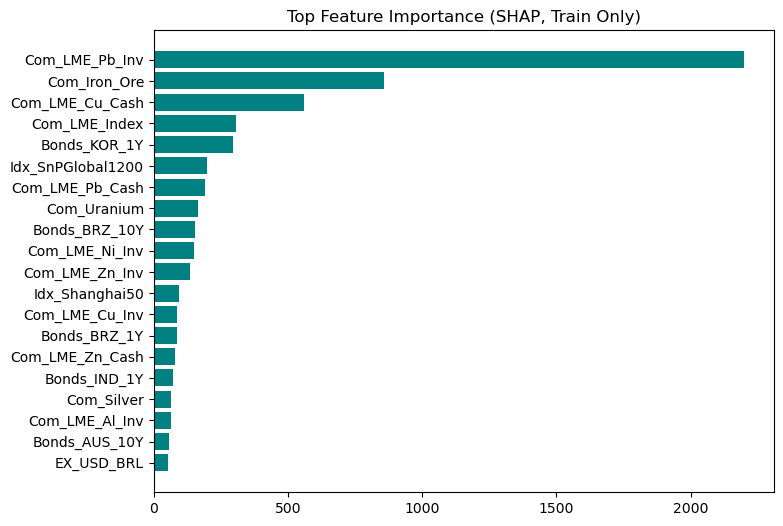

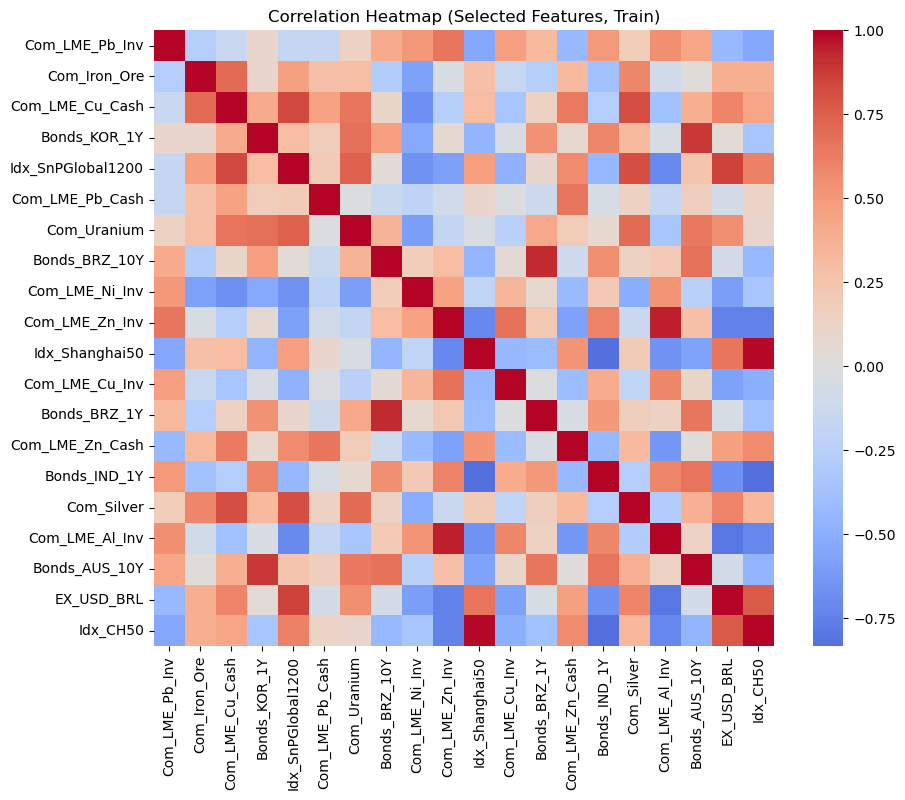

In [32]:
# 3.1 피처 중요도 및 상관관계
top_feat = feat_imp.head(top_n).sort_values('importance')
plt.figure(figsize=(8, 6))
plt.barh(top_feat['feature'], top_feat['importance'], color='teal')
plt.title('Top Feature Importance (SHAP, Train Only)')
plt.show()

corr = X_train_all[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Selected Features, Train)')
plt.show()



### 3.2 피처 안정성 (폴드별 SHAP)
목표: 선택된 피처가 fold마다 안정적으로 유지되는지 확인.
해석: 안정성이 낮으면 피처 선택이 데이터 구간에 민감하다는 의미.


Feature stability (top 20):


,feature,count,stability
0,Com_LME_Zn_Cash,5,1.0
9,Bonds_KOR_1Y,5,1.0
18,Com_Iron_Ore,5,1.0
17,Bonds_BRZ_1Y,5,1.0
15,Com_LME_Zn_Inv,5,1.0
14,Com_LME_Pb_Cash,5,1.0
12,Idx_CH50,5,1.0
11,Com_LME_Cu_Inv,5,1.0
10,Com_LME_Ni_Inv,5,1.0
13,Idx_Shanghai50,5,1.0


Avg Jaccard similarity: 0.780


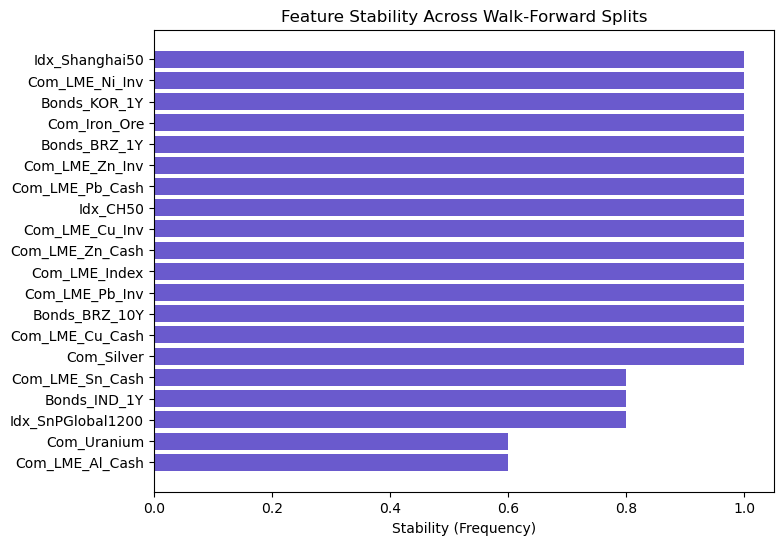

In [33]:
# 3.2 피처 안정성 (폴드별 SHAP)
from collections import Counter

fs_val_horizon = 12
fs_n_samples = len(X_train_all)
fs_max_splits = max(1, (fs_n_samples // fs_val_horizon) - 1)
fs_n_splits = min(5, fs_max_splits)

fs_splits = []
for i in range(fs_n_splits):
    val_end = fs_n_samples - (fs_n_splits - 1 - i) * fs_val_horizon
    val_start = val_end - fs_val_horizon
    train_end = val_start
    fs_splits.append((slice(0, train_end), slice(val_start, val_end)))

feature_sets = []
for tr_slice, _ in fs_splits:
    X_fs = X_train_all.iloc[tr_slice]
    y_fs = y_train.iloc[tr_slice]
    model_fs = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model_fs.fit(X_fs, y_fs)
    explainer_fs = shap.TreeExplainer(model_fs)
    shap_val_fs = explainer_fs.shap_values(X_fs)
    importances_fs = np.abs(shap_val_fs).mean(axis=0)
    feat_imp_fs = pd.DataFrame({"feature": X_fs.columns, "importance": importances_fs}).sort_values("importance", ascending=False)
    top_feats = feat_imp_fs.head(top_n)["feature"].tolist()
    feature_sets.append(set(top_feats))

counter = Counter([f for s in feature_sets for f in s])
stability_df = pd.DataFrame({"feature": list(counter.keys()), "count": list(counter.values())})
stability_df["stability"] = stability_df["count"] / fs_n_splits
stability_df = stability_df.sort_values("stability", ascending=False)
print("Feature stability (top 20):")
display(stability_df.head(20))

avg_jaccard = np.nan
if len(feature_sets) > 1:
    sims = []
    for i in range(len(feature_sets)):
        for j in range(i + 1, len(feature_sets)):
            a, b = feature_sets[i], feature_sets[j]
            sims.append(len(a & b) / len(a | b) if (a | b) else np.nan)
    avg_jaccard = float(np.nanmean(sims))
    print(f"Avg Jaccard similarity: {avg_jaccard:.3f}")
else:
    print("Not enough splits for stability analysis.")

feature_stability_top = stability_df.head(20)

plt.figure(figsize=(8, 6))
plt.barh(feature_stability_top.sort_values("stability")["feature"], feature_stability_top.sort_values("stability")["stability"], color="slateblue")
plt.title("Feature Stability Across Walk-Forward Splits")
plt.xlabel("Stability (Frequency)")
plt.show()



### 3.3 선택 변수의 도메인 해석

**목표**: SHAP 상위 변수들이 **왜** 니켈 가격에 영향을 주는지 경제적/산업적 관점에서 해석.

**교수님 코멘트**: 
> "샵 밸류를 뽑아서 상위에 있는 품목을 좀 뽑되, 대신 여러분들이 그 품목 변수의 **내용**을 보세요."
> "LME 가격이 30% 올랐는데 이 세상에 무슨 일이 일어났길래 30% 올랐을까? LME 변수가 올라서요 - **이건 내용적으로 설명이 안 됨**"


In [34]:
# 3.3 선택 변수의 도메인 해석

print("=" * 80)
print("3.3 SHAP Top 20 변수의 도메인 해석")
print("=" * 80)
print()

# 니켈 산업 배경 지식
print("【니켈 시장 기초 정보】")
print("-" * 80)
print("  • 주요 생산국: 인도네시아(48%), 필리핀(10%), 러시아(9%), 뉴칼레도니아(6%)")
print("  • 주요 소비국: 중국(56%), 유럽(14%), 일본(7%), 미국(6%)")
print("  • 주요 용도: 스테인리스강(68%), 배터리(12%), 합금(8%), 도금(6%)")
print("  • 가격 결정: LME(런던금속거래소)에서 일일 고시")
print()

# 도메인 해석 딕셔너리
domain_interpretation = {
    # === 파생 피처 (주의 필요) ===
    'Com_LME_Index': {
        'category': '⚠️ 파생지표',
        'warning': True,
        'interpretation': 'LME 6대 비철금속(Cu, Al, Pb, Zn, Sn, Ni) 종합 지수',
        'causal': ' 순환참조 위험: 니켈 자체가 LME Index 구성 요소 (약 15% 비중)',
        'recommendation': '예측 목적상 제외 권장 또는 니켈 제외 지수로 재계산 필요'
    },
    
    # === 니켈 직접 관련 ===
    'Com_LME_Ni_Inv': {
        'category': ' 직접 관련',
        'warning': False,
        'interpretation': 'LME 니켈 재고량 (톤)',
        'causal': ' 재고 증가 → 공급 과잉 신호 → 가격 하락 압력',
        'recommendation': '핵심 선행지표로 유지'
    },
    
    # === 연관 금속 (LME) ===
    'Com_LME_Pb_Cash': {
        'category': ' 연관 금속',
        'warning': False,
        'interpretation': 'LME 납 현물가격 ($/톤)',
        'causal': ' 비철금속 시장 동조화 현상. 글로벌 제조업 경기 동행지표',
        'recommendation': '산업 경기 프록시로 유지'
    },
    'Com_LME_Sn_Cash': {
        'category': ' 연관 금속',
        'warning': False,
        'interpretation': 'LME 주석 현물가격 ($/톤)',
        'causal': ' 전자제품 수요 지표 (납땜 용도). 니켈 배터리 수요와 동행',
        'recommendation': '전자/배터리 산업 프록시로 유지'
    },
    'Com_LME_Al_Cash': {
        'category': ' 연관 금속',
        'warning': False,
        'interpretation': 'LME 알루미늄 현물가격 ($/톤)',
        'causal': ' 경량화 산업(자동차, 항공) 지표. 에너지 비용에 민감',
        'recommendation': '제조업 프록시로 유지'
    },
    'Com_LME_Zn_Cash': {
        'category': ' 연관 금속',
        'warning': False,
        'interpretation': 'LME 아연 현물가격 ($/톤)',
        'causal': ' 아연도금강판 수요 → 건설/인프라 경기 지표',
        'recommendation': '건설 경기 프록시로 유지'
    },
    
    # === 철강/원자재 ===
    'Com_Iron_Ore': {
        'category': ' 원자재',
        'warning': False,
        'interpretation': '철광석 가격 ($/톤)',
        'causal': ' 철강 생산 원가 → 스테인리스강(니켈 68% 용도) 수요와 직결',
        'recommendation': '철강 산업 핵심 지표로 유지'
    },
    'Com_Steel': {
        'category': ' 원자재',
        'warning': False,
        'interpretation': '철강 가격',
        'causal': ' 니켈의 주요 수요처(스테인리스강)와 직접 연결',
        'recommendation': '수요측 핵심 지표로 유지'
    },
    
    # === 귀금속 ===
    'Com_Gold': {
        'category': ' 귀금속',
        'warning': False,
        'interpretation': '금 가격 ($/oz)',
        'causal': ' 안전자산 수요 지표. 금 상승 시 원자재 전반 강세 동반 경향',
        'recommendation': '리스크 센티먼트 프록시로 유지'
    },
    'Com_Silver': {
        'category': ' 귀금속',
        'warning': False,
        'interpretation': '은 가격 ($/oz)',
        'causal': ' 산업용(태양광, 전자) + 귀금속 이중 특성',
        'recommendation': '산업/귀금속 혼합 지표로 유지'
    },
    
    # === 환율 ===
    'EX_USD_BRL': {
        'category': ' 환율',
        'warning': False,
        'interpretation': '달러/브라질 헤알 환율',
        'causal': ' 브라질은 니켈 생산국(Vale社). 헤알 약세 → 달러 기준 채굴 비용 하락',
        'recommendation': '생산국 경제 지표로 유지'
    },
    'EX_USD_IDR': {
        'category': ' 환율',
        'warning': False,
        'interpretation': '달러/인도네시아 루피아 환율',
        'causal': ' 인도네시아는 세계 1위 니켈 생산국(48%). 환율 변동 → 수출 경쟁력 직결',
        'recommendation': ' 매우 중요 - 생산국 핵심 지표'
    },
    
    # === 주가지수 ===
    'Idx_CSI300': {
        'category': ' 주가지수',
        'warning': False,
        'interpretation': '중국 CSI300 지수',
        'causal': ' 중국은 니켈 최대 소비국(56%). 중국 경기 → 스테인리스강 수요 직결',
        'recommendation': ' 매우 중요 - 소비국 핵심 지표'
    },
    'Idx_Shanghai': {
        'category': ' 주가지수',
        'warning': False,
        'interpretation': '상해종합지수',
        'causal': ' CSI300과 유사. 중국 내수 경기 대리변수',
        'recommendation': '중국 경기 보조 지표로 유지'
    },
    'Idx_DxyUSD': {
        'category': ' 주가지수',
        'warning': False,
        'interpretation': '달러 인덱스 (DXY)',
        'causal': ' 달러 강세 → 원자재 가격 하락 (역의 상관관계)',
        'recommendation': '글로벌 유동성 지표로 유지'
    },
    
    # === 금리/스프레드 ===
    'Spread_US_10Y_3M': {
        'category': ' 금리',
        'warning': False,
        'interpretation': '미국 10년-3개월 금리 스프레드 (장단기 금리차)',
        'causal': ' 역전 시 경기침체 선행. 제조업 수요 감소 → 니켈 수요 하락',
        'recommendation': '경기 선행지표로 유지'
    },
    'Spread_US_10Y_2Y': {
        'category': ' 금리',
        'warning': False,
        'interpretation': '미국 10년-2년 금리 스프레드',
        'causal': ' 대표적 경기침체 선행지표',
        'recommendation': '경기 선행지표로 유지'
    },
    'Bonds_KOR_10Y': {
        'category': ' 금리',
        'warning': False,
        'interpretation': '한국 10년 국채 금리',
        'causal': '⚠️ 한국은 니켈 주요 생산/소비국이 아님. 간접적 아시아 경기 지표',
        'recommendation': '우선순위 낮음 - 제외 검토 가능'
    },
    
    # === 에너지 ===
    'Com_Uranium': {
        'category': ' 에너지',
        'warning': False,
        'interpretation': '우라늄 가격',
        'causal': '⚠️ 니켈과 직접 연관성 낮음. 에너지 전환 테마로 동반 상승 가능',
        'recommendation': '간접 지표 - 제외 검토 가능'
    },
}

# SHAP Top 20 출력
print("【SHAP Top 20 변수 도메인 해석】")
print("-" * 80)
print()

for i, (feature, importance) in enumerate(feat_imp.head(20).values, 1):
    # 변수명에서 _log_ret, _diff 제거하여 기본 변수명 추출
    base_feature = feature.replace('_log_ret', '').replace('_diff', '')
    
    if base_feature in domain_interpretation:
        info = domain_interpretation[base_feature]
        warning_icon = "" if info['warning'] else ""
        print(f"{i:2d}. {feature}")
        print(f"    {info['category']} {warning_icon}")
        print(f"    정의: {info['interpretation']}")
        print(f"    인과: {info['causal']}")
        print(f"    권장: {info['recommendation']}")
    else:
        print(f"{i:2d}. {feature}")
        print(f"    ⚪ 도메인 정보 미등록")
    print()

print("=" * 80)
print()

# 경고 요약
print("【⚠️ 파생 피처 경고】")
print("-" * 80)
print()
print("Com_LME_Index가 SHAP 1, 2위를 차지했으나, 이는 '순환참조' 문제가 있습니다.")
print()
print("문제점:")
print("  • LME Index = Cu + Al + Pb + Zn + Sn + **Ni** 의 가중 평균")
print("  • 니켈 가격이 오르면 LME Index도 오름 → 당연히 상관관계 높음")
print("  • 이는 '예측'이 아니라 '동어반복'에 가까움")
print()
print("교수님 코멘트:")
print('  "LME 가격이 30% 올랐는데 왜 올랐을까? LME 변수가 올라서요"')
print('  "이건 내용적으로 설명이 안 됨"')
print()
print("권장 조치:")
print("  1. LME Index를 피처에서 제외하거나")
print("  2. 니켈 제외 LME Index를 별도 계산하여 사용")
print()

print("=" * 80)
print()

# 핵심 인과관계 요약
print("【핵심 인과 관계 요약】")
print("-" * 80)
print()
print("1. 공급측 요인 (생산국)")
print("   인도네시아(48%) → EX_USD_IDR 환율 → 채굴 비용 → 니켈 공급")
print("   러시아(9%) → 지정학적 리스크 → 공급 불안 → 가격 상승")
print()
print("2. 수요측 요인 (소비국)")
print("   중국(56%) → CSI300/Shanghai 지수 → 제조업 경기 → 스테인리스강 수요")
print("   → 철강/철광석 가격과 동행")
print()
print("3. 거시경제 요인")
print("   달러 강세(DXY ↑) → 원자재 약세(Ni ↓) [역의 관계]")
print("   금리 스프레드 역전 → 경기침체 우려 → 니켈 수요 감소")
print()
print("4. 재고 요인")
print("   LME 니켈 재고(Ni_Inv) ↑ → 공급 과잉 → 가격 하락 압력")
print()


3.3 SHAP Top 20 변수의 도메인 해석

【니켈 시장 기초 정보】
--------------------------------------------------------------------------------
  • 주요 생산국: 인도네시아(48%), 필리핀(10%), 러시아(9%), 뉴칼레도니아(6%)
  • 주요 소비국: 중국(56%), 유럽(14%), 일본(7%), 미국(6%)
  • 주요 용도: 스테인리스강(68%), 배터리(12%), 합금(8%), 도금(6%)
  • 가격 결정: LME(런던금속거래소)에서 일일 고시

【SHAP Top 20 변수 도메인 해석】
--------------------------------------------------------------------------------

 1. Com_LME_Pb_Inv
    ⚪ 도메인 정보 미등록

 2. Com_Iron_Ore
    🟢 원자재 
    정의: 철광석 가격 ($/톤)
    인과: ✅ 철강 생산 원가 → 스테인리스강(니켈 68% 용도) 수요와 직결
    권장: 철강 산업 핵심 지표로 유지

 3. Com_LME_Cu_Cash
    ⚪ 도메인 정보 미등록

 4. Com_LME_Index
    ⚠️ 파생지표 🚨
    정의: LME 6대 비철금속(Cu, Al, Pb, Zn, Sn, Ni) 종합 지수
    인과: ❌ 순환참조 위험: 니켈 자체가 LME Index 구성 요소 (약 15% 비중)
    권장: 예측 목적상 제외 권장 또는 니켈 제외 지수로 재계산 필요

 5. Bonds_KOR_1Y
    ⚪ 도메인 정보 미등록

 6. Idx_SnPGlobal1200
    ⚪ 도메인 정보 미등록

 7. Com_LME_Pb_Cash
    🟡 연관 금속 
    정의: LME 납 현물가격 ($/톤)
    인과: ✅ 비철금속 시장 동조화 현상. 글로벌 제조업 경기 동행지표
    권장: 산업 경기 프록시로 유지

 8. Com_Uranium
    

### 3.4 파생 피처 제외 실험

**목표**: LME Index(파생지표)를 제외했을 때 성능 변화 확인.

**이유**: 
- LME Index는 니켈 가격을 포함하는 종합지수 → 순환참조 문제
- 예측이 아닌 동어반복에 가까움
- 실제 인과관계가 있는 변수로만 예측하는 것이 해석 가능성 향상


In [35]:
# 3.4 파생 피처 제외 실험

# LME Index 제외한 피처 선택
excluded_patterns = ['Com_LME_Index']  # 제외할 패턴

# 제외 전 피처
features_with_lme = selected_features.copy()
print(f"LME Index 포함 피처 수: {len(features_with_lme)}")

# LME Index 관련 피처 제외
features_without_lme = [f for f in selected_features 
                        if not any(p in f for p in excluded_patterns)]

# 제외된 피처 목록
excluded_features = [f for f in selected_features if f not in features_without_lme]
print(f"제외된 피처: {excluded_features}")
print(f"LME Index 제외 후 피처 수: {len(features_without_lme)}")

# 부족한 피처 보충 (SHAP 순위에서 다음 순위 추가)
n_excluded = len(excluded_features)
if n_excluded > 0:
    # feat_imp에서 제외 피처 다음 순위 가져오기
    remaining_features = [f for f in feat_imp['feature'].tolist() 
                          if f not in features_with_lme 
                          and not any(p in f for p in excluded_patterns)]
    replacement_features = remaining_features[:n_excluded]
    features_without_lme.extend(replacement_features)
    print(f"대체 추가된 피처: {replacement_features}")

print(f"최종 피처 수: {len(features_without_lme)}")
print()

# 피처 비교 테이블
print("【피처 구성 비교】")
print("-" * 70)
print(f"{'순위':<4} {'LME Index 포함':<35} {'LME Index 제외':<35}")
print("-" * 70)
for i in range(max(len(features_with_lme), len(features_without_lme))):
    f1 = features_with_lme[i] if i < len(features_with_lme) else '-'
    f2 = features_without_lme[i] if i < len(features_without_lme) else '-'
    marker = '⚠️' if 'LME_Index' in f1 else '  '
    print(f"{i+1:<4} {marker}{f1:<33} {f2:<35}")
print("-" * 70)
print()

# 설정 옵션 (실험용)
EXCLUDE_LME_INDEX = True  # True: 파생피처 제외, False: 포함

if EXCLUDE_LME_INDEX:
    selected_features_final = features_without_lme
    print(" 설정: LME Index 제외 (EXCLUDE_LME_INDEX = True)")
    print("   → 순환참조 제거, 해석 가능한 피처만 사용")
else:
    selected_features_final = features_with_lme
    print("⚠️ 설정: LME Index 포함 (EXCLUDE_LME_INDEX = False)")
    print("   → 성능은 높을 수 있으나 해석에 주의 필요")

print()
print(f"최종 선택 피처 ({len(selected_features_final)}개): {selected_features_final[:5]}...")


LME Index 포함 피처 수: 20
제외된 피처: []
LME Index 제외 후 피처 수: 20
최종 피처 수: 20

【피처 구성 비교】
----------------------------------------------------------------------
순위   LME Index 포함                        LME Index 제외                       
----------------------------------------------------------------------
1      Com_LME_Pb_Inv                    Com_LME_Pb_Inv                     
2      Com_Iron_Ore                      Com_Iron_Ore                       
3      Com_LME_Cu_Cash                   Com_LME_Cu_Cash                    
4      Bonds_KOR_1Y                      Bonds_KOR_1Y                       
5      Idx_SnPGlobal1200                 Idx_SnPGlobal1200                  
6      Com_LME_Pb_Cash                   Com_LME_Pb_Cash                    
7      Com_Uranium                       Com_Uranium                        
8      Bonds_BRZ_10Y                     Bonds_BRZ_10Y                      
9      Com_LME_Ni_Inv                    Com_LME_Ni_Inv                     
10     

## 4. 모델 학습 및 평가

**실험 흐름:**
1. **베이스라인**: 5개 모델 전체 비교 → 최적 모델 선정
2. **Residual 스태킹**: 최적 베이스라인 기반 조합 탐색 → 상위 2개 선정
3. **ROR 스태킹**: 상위 2개 Residual 조합 기반 확장 → 최종 모델 선정

핵심: **잘 나온 것 위주로 깊이 있게** 분석


### 4.1 베이스라인 모델 (전체 비교)

**목표**: 5개 모델 단독 성능 비교 → 최적 베이스라인 선정

| 모델 | 역할 |
|------|------|
| GradientBoosting | 안정적 기준선 |
| XGBoost | 강한 비선형 학습 |
| LightGBM | 빠른 잔차 안정화 |
| CatBoost | 과적합 억제 |
| AdaBoost | 약한 학습기 부스팅 |


In [36]:
# 4.0 모델링 유틸리티
import math
from sklearn.model_selection import ParameterSampler
from typing import Dict, List, Tuple, Optional

RANDOM_SEED = CONFIG['random_seed']

# ============================================================
#  평가 메트릭 함수
# ============================================================

def eval_metrics(y_true, y_pred) -> Tuple[float, float, float, float]:
    """
    회귀 모델 평가 메트릭 계산
    
    반환값:
        rmse: Root Mean Squared Error
        rmspe: Root Mean Squared Percentage Error (%)
        mape: Mean Absolute Percentage Error (%)
        mae: Mean Absolute Error
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # 0 나눗셈 방지
    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, np.nan, np.abs(y_true))
    ape = np.abs((y_true - y_pred) / denom)
    spe = ((y_true - y_pred) / denom) ** 2
    
    mape = np.nanmean(ape) * 100
    rmspe = np.sqrt(np.nanmean(spe)) * 100
    
    return rmse, rmspe, mape, mae


def eval_metrics_with_ci(y_true, y_pred, n_bootstrap=100) -> Dict:
    """
    부트스트랩 기반 신뢰구간 포함 메트릭 
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    
    rmse_samples = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        rmse_boot = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
        rmse_samples.append(rmse_boot)
    
    rmse, rmspe, mape, mae = eval_metrics(y_true, y_pred)
    
    return {
        'rmse': rmse,
        'rmse_ci_lower': np.percentile(rmse_samples, 2.5),
        'rmse_ci_upper': np.percentile(rmse_samples, 97.5),
        'rmspe': rmspe,
        'mape': mape,
        'mae': mae
    }


# ============================================================
# ️ 모델 빌더 함수
# ============================================================

def build_model(name: str, params: Optional[Dict] = None):
    """모델 인스턴스 생성"""
    params = params or {}
    seed = CONFIG['random_seed']
    
    model_configs = {
        'XGBoost': {
            'class': xgb.XGBRegressor,
            'default': {'n_estimators': 500, 'learning_rate': 0.05, 
                       'random_state': seed, 'n_jobs': -1}
        },
        'LightGBM': {
            'class': lgb.LGBMRegressor,
            'default': {'n_estimators': 500, 'learning_rate': 0.05,
                       'random_state': seed, 'n_jobs': -1, 'verbose': -1}
        },
        'CatBoost': {
            'class': CatBoostRegressor,
            'default': {'n_estimators': 500, 'learning_rate': 0.05,
                       'random_state': seed, 'verbose': 0, 'allow_writing_files': False}
        },
        'GradientBoosting': {
            'class': GradientBoostingRegressor,
            'default': {'n_estimators': 500, 'learning_rate': 0.05,
                       'random_state': seed}
        },
        'AdaBoost': {
            'class': AdaBoostRegressor,
            'default': {'n_estimators': 300, 'learning_rate': 0.05,
                       'random_state': seed}
        }
    }
    
    if name not in model_configs:
        raise ValueError(f"Unknown model: {name}")
    
    cfg = model_configs[name]
    final_params = {**cfg['default'], **params}
    return cfg['class'](**final_params)


# ============================================================
#  백테스트 유틸리티 (: 거래비용 포함)
# ============================================================

def calculate_returns_with_costs(
    y_true, y_pred, prev_prices,
    threshold: float = 0.005,
    transaction_cost: float = None,
    slippage: float = None
) -> Dict:
    """
    거래비용과 슬리피지를 포함한 수익률 계산 
    
    인자:
        threshold: 거래 진입 임계값
        transaction_cost: 거래비용 (예: 0.001 = 0.1%)
        slippage: 슬리피지 (예: 0.0005 = 0.05%)
    """
    if transaction_cost is None:
        transaction_cost = CONFIG['transaction_cost']
    if slippage is None:
        slippage = CONFIG['slippage']
    
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    prev_prices = np.asarray(prev_prices)
    
    # 예측 수익률
    pred_ret = (y_pred - prev_prices) / prev_prices
    actual_ret = (y_true - prev_prices) / prev_prices
    
    # 포지션 결정 (threshold 이상일 때만 진입)
    positions = np.where(np.abs(pred_ret) > threshold, np.sign(pred_ret), 0)
    
    # 거래 발생 시점
    trades = np.abs(np.diff(positions, prepend=0)) > 0
    n_trades = trades.sum()
    
    # 총 비용 (거래 시 발생)
    total_cost = trades * (transaction_cost + slippage)
    
    # 순수익률 = 실제수익률 * 포지션 - 비용
    gross_returns = actual_ret * positions
    net_returns = gross_returns - total_cost
    
    cumulative_gross = (1 + gross_returns).prod() - 1
    cumulative_net = (1 + net_returns).prod() - 1
    
    return {
        'n_trades': n_trades,
        'gross_return': cumulative_gross,
        'net_return': cumulative_net,
        'total_cost': total_cost.sum(),
        'avg_return_per_trade': cumulative_net / n_trades if n_trades > 0 else 0,
        'win_rate': (gross_returns[positions != 0] > 0).mean() if (positions != 0).any() else 0
    }


def calculate_sharpe_ratio(returns: np.ndarray, risk_free_rate: float = 0.02) -> float:
    """연율화 샤프 비율 계산 """
    excess_returns = returns - risk_free_rate / 52  # 주간 무위험 수익률
    if excess_returns.std() == 0:
        return 0
    return np.sqrt(52) * excess_returns.mean() / excess_returns.std()


def calculate_max_drawdown(cumulative_returns: np.ndarray) -> float:
    """최대 낙폭(MDD) 계산"""
    cumulative = (1 + cumulative_returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()


# ============================================================
#  ROR/Residual 유틸리티
# ============================================================

def compute_prev_prices(price_full, idx):
    """이전 가격 계산 (가격 레벨 series 기준, 첫 시점 예외 처리)"""
    idx = pd.Index(idx)
    if len(idx) == 0:
        return y.shift(1).reindex(idx).copy()
    
    prev = y.shift(1).reindex(idx).copy()
    if pd.isna(prev.iloc[0]):
        prior = y.loc[y.index < idx[0]]
        if len(prior) > 0:
            prev.iloc[0] = prior.iloc[-1]
        else:
            prev.iloc[0] = y.loc[idx[0]]
    return prev


def make_meta_features(X, base_pred, resid_pred):
    """메타 피처 생성 (스태킹용)"""
    X_meta = X.copy()
    X_meta['base_pred'] = base_pred
    X_meta['resid_pred'] = resid_pred
    return X_meta


def ror_target(y_true, prev_prices, base_pred, resid_pred, mode=None):
    """ROR 타겟 계산"""
    if mode is None:
        mode = CONFIG['ror_target_mode']
    
    if mode == 'return':
        return (y_true / prev_prices) - 1
    elif mode == 'pred_minus_residual':
        return (2 * base_pred) - y_true
    raise ValueError(f"Unknown ROR mode: {mode}")


def ror_pred_to_price(ror_pred, prev_prices, base_pred, resid_pred, mode=None):
    """ROR 예측값을 가격으로 변환"""
    if mode is None:
        mode = CONFIG['ror_target_mode']
    
    if mode == 'return':
        return prev_prices * (1 + ror_pred)
    elif mode == 'pred_minus_residual':
        return (2 * base_pred) - ror_pred
    raise ValueError(f"Unknown ROR mode: {mode}")


# ============================================================
#  하이퍼파라미터 공간 (정리됨)
# ============================================================

PARAM_SPACES = {
    'XGBoost': {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    },
    'LightGBM': {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'subsample': [0.6, 0.8, 1.0],
    },
    'CatBoost': {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'depth': [4, 6, 8],
    },
    'GradientBoosting': {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.05, 0.1],
    }
}

def get_param_grid(model_name: str, n_samples: int = None) -> List[Dict]:
    """하이퍼파라미터 샘플링"""
    if n_samples is None:
        n_samples = CONFIG['tuning_budget'].get(model_name, 10)
    
    sampler = ParameterSampler(
        PARAM_SPACES[model_name], 
        n_iter=n_samples, 
        random_state=RANDOM_SEED
    )
    return list(sampler)


# 모델 풀 정의
ALL_MODELS = list(PARAM_SPACES.keys())
BASELINE_MODELS = ALL_MODELS
RESIDUAL_MODELS = ALL_MODELS
ROR_MODELS = ALL_MODELS

# 파라미터 그리드 생성
param_grids = {name: get_param_grid(name) for name in ALL_MODELS}

print(" 모델링 유틸리티 로드 완료")
print(f"  - 모델 종류: {ALL_MODELS}")
print(f"  - 거래비용: {CONFIG['transaction_cost']*100:.2f}%")
print(f"  - 슬리피지: {CONFIG['slippage']*100:.3f}%")


✅ 모델링 유틸리티 로드 완료
  - 모델 종류: ['XGBoost', 'LightGBM', 'CatBoost', 'GradientBoosting', 'AdaBoost']
  - 거래비용: 0.10%
  - 슬리피지: 0.050%


In [37]:
# 4.1 베이스라인 모델
preds = pd.DataFrame(index=y_test.index)
preds['Actual'] = y_test
results = []

prev_price = y.shift(1).loc[y_test.index].copy()
prev_prev_price = y.shift(2).loc[y_test.index].copy()

last_before_test = y.loc[y.index < y_test.index[0]]
if len(last_before_test) < 2:
    raise ValueError("Not enough history before test to build baselines.")

# 테스트 첫 시점 가격 채움 (검증 마지막 값 사용))
prev_price.iloc[0] = last_before_test.iloc[-1]
prev_prev_price.iloc[0] = last_before_test.iloc[-2]

naive_last = prev_price
naive_drift = prev_price + (prev_price - prev_prev_price)

baseline_models = {
    'Naive_Last': naive_last,
    'Naive_Drift': naive_drift
}

baseline_rows = []
for name, y_pred in baseline_models.items():
    preds[name] = y_pred
    rmse, rmspe, mape, mae = eval_metrics(y_test, y_pred)
    row = {
        'Model': name,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'MAPE': mape,
        'MAE': mae
    }
    results.append(row)
    baseline_rows.append(row)

baseline_results_df = pd.DataFrame(baseline_rows).set_index('Model')
print("Baseline Results (Test):")
display(baseline_results_df)



Baseline Results (Test):


,RMSE,RMSPE,MAPE,MAE
Model,,,,
Naive_Last,569.225486,3.498880,2.577581,410.000000
Naive_Drift,480.665760,3.070722,2.103092,325.763889


### 4.2 Residual 스태킹 (최적 베이스라인 기반)

**전략**:
- 베이스라인 중 **GradientBoosting이 최고 성능** → 이를 기반으로 Residual 조합 탐색
- 모든 조합을 탐색하되, **상위 2개 조합에 집중** 분석

**Residual 스태킹 원리**:
```
잔차 = 실제값 - Baseline 예측
최종 예측 = Baseline 예측 + Residual 예측
```


In [38]:
# 4.2 베이스라인 모델 선택 (학습 -> 검증)
baseline_search_rows = []
best_params_by_model = {}
base_pred_train = {}
base_pred_val = {}

for model_name in BASELINE_MODELS:
    best_rmse = math.inf
    best_params = None
    for params in param_grids[model_name]:
        model = build_model(model_name, params)
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        rmse, rmspe, mape, mae = eval_metrics(y_val, y_pred_val)
        baseline_search_rows.append({
            'Model': model_name,
            'Params': params,
            'VAL_RMSE': rmse,
            'VAL_RMSPE': rmspe,
            'VAL_MAPE': mape,
            'VAL_MAE': mae
        })
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    best_params_by_model[model_name] = best_params

    # 잔차/ROR 스태킹을 위한 최적 베이스라인 예측값 계산
    model = build_model(model_name, best_params)
    model.fit(X_train, y_train)
    base_pred_train[model_name] = model.predict(X_train)
    base_pred_val[model_name] = model.predict(X_val)

baseline_search_df = pd.DataFrame(baseline_search_rows)
baseline_val_df = baseline_search_df.sort_values('VAL_RMSE').groupby('Model').head(1).set_index('Model')
print("Baseline validation (best params per model):")
display(baseline_val_df)

# 베이스라인 순위 (전체 모델)
baseline_rank_df = baseline_val_df.sort_values('VAL_RMSE')
best_baseline_model = baseline_rank_df.index[0] if len(baseline_rank_df) > 0 else None
print(f"Best baseline (val): {best_baseline_model}")



Baseline validation (best params per model):


,Params,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
Model,,,,,
GradientBoosting,"{'n_estimators': 600, 'max_depth': 4, 'learnin...",106.945849,0.716466,0.545884,81.821019
XGBoost,"{'subsample': 0.8, 'n_estimators': 300, 'max_d...",144.731601,0.969872,0.798923,119.654134
CatBoost,"{'n_estimators': 600, 'learning_rate': 0.1, 'd...",174.082338,1.156331,0.939339,141.322155
LightGBM,"{'subsample': 0.6, 'num_leaves': 31, 'n_estima...",190.972098,1.268298,1.000120,150.489590
AdaBoost,"{'n_estimators': 100, 'learning_rate': 0.01}",1214.105151,8.085421,8.044997,1208.909834


Best baseline (val): GradientBoosting


### 4.2.1 Validation Summary
목표: baseline 및 조합 성능 요약.



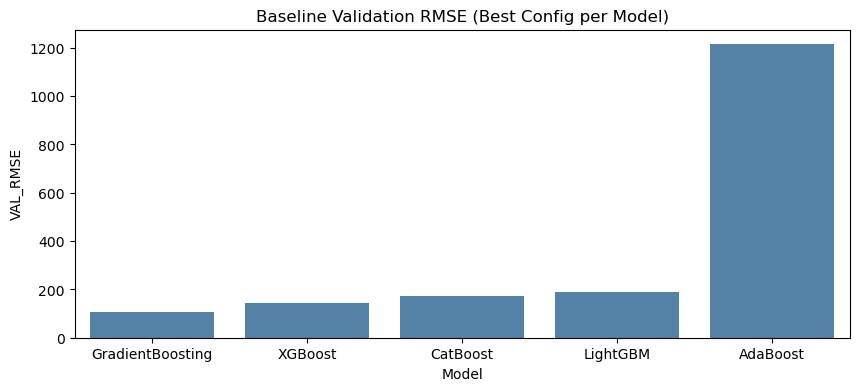

In [39]:
# 4.2.1 검증 결과 요약 시각화
val_order = baseline_val_df.sort_values('VAL_RMSE').index.tolist()

plt.figure(figsize=(10, 4))
sns.barplot(x=baseline_val_df.loc[val_order].index, y=baseline_val_df.loc[val_order]['VAL_RMSE'], color='steelblue')
plt.title("Baseline Validation RMSE (Best Config per Model)")
plt.xticks(rotation=0)
plt.show()



### 4.3 ROR 스태킹 (상위 Residual 조합 기반)

**전략**:
- Residual 스태킹 상위 2개 조합을 기반으로 ROR 확장
- 3단계 스태킹으로 최종 성능 극대화 시도

**ROR 스태킹 원리**:
```
ROR = Baseline 예측 - Residual (= 2*Baseline - 실제)
최종 예측 = 이전 가격 × (1 + ROR 예측)
```

**주의**: 3단계 스태킹은 과적합 위험이 있음 → 테스트 결과로 검증


In [40]:
# 4.3 잔차 + ROR 조합 탐색 (검증)
resid_search_rows = []

# 사전 계산 prev prices for ROR target on train/val
prev_train = compute_prev_prices(price_full, X_train.index)
prev_val = compute_prev_prices(price_full, X_val.index)

# 잔차 조합: base + residual (params grid on residual)
base_candidates = baseline_rank_df.index.tolist() if 'baseline_rank_df' in globals() and len(baseline_rank_df) > 0 else BASELINE_MODELS

for base_name in base_candidates:
    base_train_pred = base_pred_train[base_name]
    base_val_pred = base_pred_val[base_name]
    resid_target_train = y_train - base_train_pred

    for resid_name in RESIDUAL_MODELS:
        for params in param_grids[resid_name]:
            resid_model = build_model(resid_name, params)
            resid_model.fit(X_train, resid_target_train)
            resid_pred_val = resid_model.predict(X_val)
            y_pred_val = base_val_pred + resid_pred_val
            rmse, rmspe, mape, mae = eval_metrics(y_val, y_pred_val)

            resid_search_rows.append({
                'Base': base_name,
                'Residual': resid_name,
                'Residual_Params': params,
                'VAL_RMSE': rmse,
                'VAL_RMSPE': rmspe,
                'VAL_MAPE': mape,
                'VAL_MAE': mae
            })

resid_search_df = pd.DataFrame(resid_search_rows)
resid_best_df = resid_search_df.sort_values('VAL_RMSE').groupby(['Base', 'Residual']).head(1)
resid_best_df = resid_best_df.sort_values('VAL_RMSE')

# 상위 2개 Residual 조합만 표시
print("=" * 60)
print("【Residual 스태킹 결과 - 상위 2개 조합】")
print("=" * 60)
top2_resid = resid_best_df.head(2)
display(top2_resid[['Base', 'Residual', 'VAL_RMSE', 'VAL_MAPE']])
print(f"\n→ 최적 조합: {top2_resid.iloc[0]['Base']} + {top2_resid.iloc[0]['Residual']}")
print(f"  VAL RMSE: {top2_resid.iloc[0]['VAL_RMSE']:.2f}")

best_resid_combo = resid_best_df.iloc[0] if len(resid_best_df) > 0 else None

# ROR 조합: base + residual + ror (params grid on ror)
ror_search_rows = []
resid_candidates = resid_best_df

for _, row in resid_candidates.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']
    resid_params = row['Residual_Params']

    base_train_pred = base_pred_train[base_name]
    base_val_pred = base_pred_val[base_name]
    resid_target_train = y_train - base_train_pred

    # 잔차 모델 학습 model (best params) to get train/val residual preds
    resid_model = build_model(resid_name, resid_params)
    resid_model.fit(X_train, resid_target_train)
    resid_pred_train = resid_model.predict(X_train)
    resid_pred_val = resid_model.predict(X_val)

    X_train_meta = make_meta_features(X_train, base_train_pred, resid_pred_train)
    X_val_meta = make_meta_features(X_val, base_val_pred, resid_pred_val)

    ror_y_train = ror_target(y_train, prev_train, base_train_pred, resid_pred_train, mode=CONFIG['ror_target_mode'])

    for ror_name in ROR_MODELS:
        for ror_params in param_grids[ror_name]:
            ror_model = build_model(ror_name, ror_params)
            ror_model.fit(X_train_meta, ror_y_train)
            ror_pred_val = ror_model.predict(X_val_meta)
            y_pred_val = ror_pred_to_price(ror_pred_val, prev_val, base_val_pred, resid_pred_val, mode=CONFIG['ror_target_mode'])
            rmse, rmspe, mape, mae = eval_metrics(y_val, y_pred_val)

            ror_search_rows.append({
                'Base': base_name,
                'Residual': resid_name,
                'ROR': ror_name,
                'Residual_Params': resid_params,
                'ROR_Params': ror_params,
                'VAL_RMSE': rmse,
                'VAL_RMSPE': rmspe,
                'VAL_MAPE': mape,
                'VAL_MAE': mae
            })

ror_search_df = pd.DataFrame(ror_search_rows)
ror_best_df = ror_search_df.sort_values('VAL_RMSE').groupby(['Base', 'Residual', 'ROR']).head(1)
ror_best_df = ror_best_df.sort_values('VAL_RMSE')

# 상위 2개 ROR 조합만 표시
print("\n" + "=" * 60)
print("【ROR 스태킹 결과 - 상위 2개 조합】")
print("=" * 60)
top2_ror = ror_best_df.head(2)
display(top2_ror[['Base', 'Residual', 'ROR', 'VAL_RMSE', 'VAL_MAPE']])
print(f"\n→ 최적 조합: {top2_ror.iloc[0]['Base']} + {top2_ror.iloc[0]['Residual']} + {top2_ror.iloc[0]['ROR']}")
print(f"  VAL RMSE: {top2_ror.iloc[0]['VAL_RMSE']:.2f}")

best_ror_combo = ror_best_df.iloc[0] if len(ror_best_df) > 0 else None



Top Residual combos (val):


,Base,Residual,Residual_Params,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
28,GradientBoosting,LightGBM,"{'subsample': 0.6, 'num_leaves': 31, 'n_estima...",92.202813,0.613872,0.540180,81.199583
15,GradientBoosting,XGBoost,"{'subsample': 1.0, 'n_estimators': 300, 'max_d...",93.167843,0.621083,0.545483,81.939769
104,XGBoost,CatBoost,"{'n_estimators': 900, 'learning_rate': 0.03, '...",97.019134,0.647150,0.525948,79.040659
62,GradientBoosting,AdaBoost,"{'n_estimators': 400, 'learning_rate': 0.1}",98.746716,0.659492,0.549353,82.470934
87,XGBoost,LightGBM,"{'subsample': 1.0, 'num_leaves': 63, 'n_estima...",100.324757,0.664810,0.559170,84.272750
39,GradientBoosting,CatBoost,"{'n_estimators': 300, 'learning_rate': 0.01, '...",103.030431,0.684842,0.587236,88.306117
74,XGBoost,XGBoost,"{'subsample': 0.8, 'n_estimators': 900, 'max_d...",103.284354,0.684230,0.557923,84.075684
48,GradientBoosting,GradientBoosting,"{'n_estimators': 200, 'max_depth': 2, 'learnin...",105.053871,0.703264,0.538147,80.696728
109,XGBoost,GradientBoosting,"{'n_estimators': 200, 'max_depth': 2, 'learnin...",117.890742,0.787171,0.609010,91.451803
122,XGBoost,AdaBoost,"{'n_estimators': 400, 'learning_rate': 0.05}",142.190197,0.952824,0.788880,118.163376


Top ROR combos (val):


,Base,Residual,ROR,Residual_Params,ROR_Params,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
368,GradientBoosting,CatBoost,GradientBoosting,"{'n_estimators': 300, 'learning_rate': 0.01, '...","{'n_estimators': 200, 'max_depth': 4, 'learnin...",73.766901,0.487123,0.327551,49.531527
485,GradientBoosting,GradientBoosting,GradientBoosting,"{'n_estimators': 200, 'max_depth': 2, 'learnin...","{'n_estimators': 600, 'max_depth': 4, 'learnin...",75.410441,0.501651,0.457624,68.795714
233,GradientBoosting,AdaBoost,GradientBoosting,"{'n_estimators': 400, 'learning_rate': 0.1}","{'n_estimators': 600, 'max_depth': 4, 'learnin...",77.713360,0.513649,0.397305,59.930924
46,GradientBoosting,LightGBM,GradientBoosting,"{'subsample': 0.6, 'num_leaves': 31, 'n_estima...","{'n_estimators': 200, 'max_depth': 2, 'learnin...",78.745671,0.520848,0.410956,62.005649
1106,AdaBoost,CatBoost,CatBoost,"{'n_estimators': 900, 'learning_rate': 0.05, '...","{'n_estimators': 300, 'learning_rate': 0.05, '...",83.945526,0.559295,0.508002,76.292877
...,...,...,...,...,...,...,...,...,...
1378,AdaBoost,XGBoost,AdaBoost,"{'subsample': 1.0, 'n_estimators': 600, 'max_d...","{'n_estimators': 200, 'learning_rate': 0.01}",897.213246,5.974123,5.944108,893.286692
1448,AdaBoost,GradientBoosting,AdaBoost,"{'n_estimators': 600, 'max_depth': 4, 'learnin...","{'n_estimators': 400, 'learning_rate': 0.1}",1101.003312,7.327153,7.299373,1097.248968
1133,AdaBoost,CatBoost,AdaBoost,"{'n_estimators': 900, 'learning_rate': 0.05, '...","{'n_estimators': 400, 'learning_rate': 0.1}",1142.542417,7.609070,7.569356,1137.421949
1504,AdaBoost,LightGBM,AdaBoost,"{'subsample': 0.6, 'num_leaves': 31, 'n_estima...","{'n_estimators': 200, 'learning_rate': 0.01}",1261.240474,8.383221,8.295192,1247.753837


### 4.4 Residual Diagnostics
목표: best residual combo의 잔차 분포와 자기상관 확인.



In [41]:
# (빈 셀)
pass


Selected model for backtests: ROR_GradientBoosting+CatBoost+GradientBoosting
Residual Correction: Base vs Residual (Best Combo)
Base   RMSE=1175.3932, RMSPE=6.97, MAPE=5.44, MAE=877.3477
Resid. RMSE=1204.3255, RMSPE=7.12, MAPE=5.52, MAE=893.2096


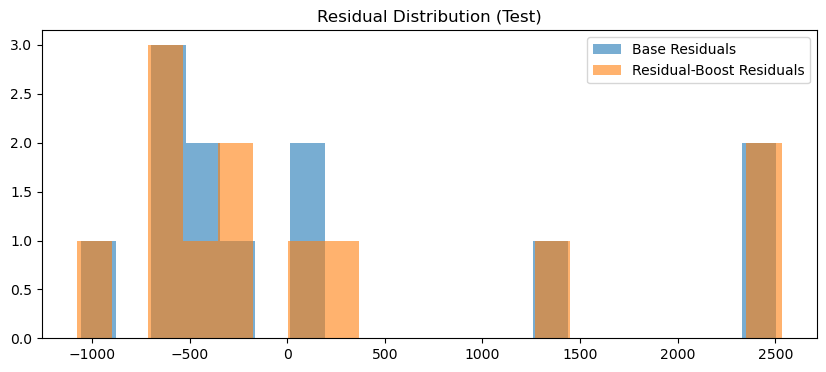

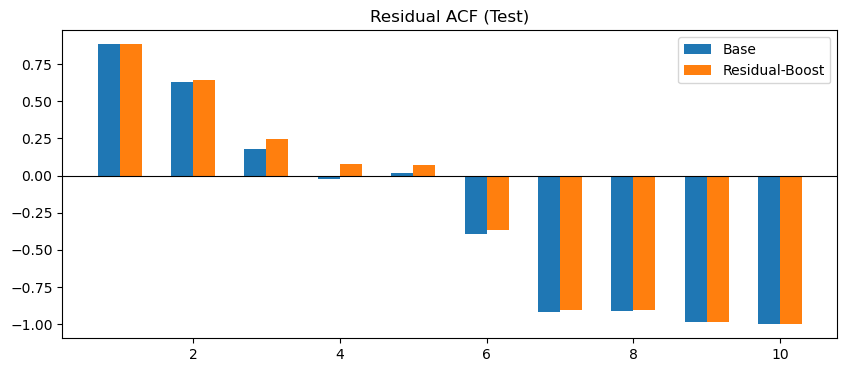

In [42]:
# 4.4 테스트 평가 (베이스라인/잔차/ROR) + 잔차 진단
# 전체 학습 데이터 준비 (학습 + 검증)
X_train_full = pd.concat([X_train_all, X_val_all])
y_train_full = pd.concat([y_train, y_val])
X_train_full = X_train_full[selected_features]

# ROR 계산용 이전 가격
prev_train_full = compute_prev_prices(price_full, X_train_full.index)
prev_test = compute_prev_prices(price_full, X_test.index)

# 베이스라인 모델 (전체학습 -> 테스트)
base_pred_train_full = {}
base_pred_test = {}

for model_name in BASELINE_MODELS:
    params = best_params_by_model[model_name]
    model = build_model(model_name, params)
    model.fit(X_train_full, y_train_full)

    base_pred_train_full[model_name] = model.predict(X_train_full)
    pred_test = model.predict(X_test)
    base_pred_test[model_name] = pred_test

    model_key = f"BASE_{model_name}"
    preds[model_key] = pred_test

    rmse, rmspe, mape, mae = eval_metrics(y_test, pred_test)
    results.append({
        'Model': model_key,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'MAPE': mape,
        'MAE': mae
    })

# 잔차 조합 (top K from validation)
resid_eval_rows = []
best_resid_name = None
best_resid_pred_test = None
best_base_pred_test = None

resid_candidates = resid_best_df if len(resid_best_df) > 0 else pd.DataFrame()
for _, row in resid_candidates.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']
    resid_params = row['Residual_Params']

    resid_target_train_full = y_train_full - base_pred_train_full[base_name]
    resid_model = build_model(resid_name, resid_params)
    resid_model.fit(X_train_full, resid_target_train_full)

    resid_pred_test = resid_model.predict(X_test)
    pred_test = base_pred_test[base_name] + resid_pred_test

    model_key = f"RES_{base_name}+{resid_name}"
    preds[model_key] = pred_test

    rmse, rmspe, mape, mae = eval_metrics(y_test, pred_test)
    results.append({
        'Model': model_key,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'MAPE': mape,
        'MAE': mae
    })

    resid_eval_rows.append({'Model': model_key, 'RMSE': rmse, 'MAE': mae})

    # 잔차 진단용 최적 조합 저장
    if best_resid_combo is not None and base_name == best_resid_combo['Base'] and resid_name == best_resid_combo['Residual']:
        best_resid_name = model_key
        best_resid_pred_test = pred_test
        best_base_pred_test = base_pred_test[base_name]

# ROR 조합 (top K from validation)
ror_eval_rows = []
ror_candidates = ror_best_df if len(ror_best_df) > 0 else pd.DataFrame()

for _, row in ror_candidates.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']
    ror_name = row['ROR']
    resid_params = row['Residual_Params']
    ror_params = row['ROR_Params']

    # 잔차 모델 학습 model
    resid_target_train_full = y_train_full - base_pred_train_full[base_name]
    resid_model = build_model(resid_name, resid_params)
    resid_model.fit(X_train_full, resid_target_train_full)
    resid_pred_train_full = resid_model.predict(X_train_full)
    resid_pred_test = resid_model.predict(X_test)

    # ROR 모델용 메타 피처
    X_train_meta = make_meta_features(X_train_full, base_pred_train_full[base_name], resid_pred_train_full)
    X_test_meta = make_meta_features(X_test, base_pred_test[base_name], resid_pred_test)

    ror_y_train_full = ror_target(y_train_full, prev_train_full, base_pred_train_full[base_name], resid_pred_train_full, mode=CONFIG['ror_target_mode'])
    ror_model = build_model(ror_name, ror_params)
    ror_model.fit(X_train_meta, ror_y_train_full)

    ror_pred_test = ror_model.predict(X_test_meta)
    pred_test = ror_pred_to_price(ror_pred_test, prev_test, base_pred_test[base_name], resid_pred_test, mode=CONFIG['ror_target_mode'])

    model_key = f"ROR_{base_name}+{resid_name}+{ror_name}"
    preds[model_key] = pred_test

    rmse, rmspe, mape, mae = eval_metrics(y_test, pred_test)
    results.append({
        'Model': model_key,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'MAPE': mape,
        'MAE': mae
    })

    ror_eval_rows.append({'Model': model_key, 'RMSE': rmse, 'MAE': mae})

# 백테스트용 모델 선택
if best_ror_combo is not None:
    selected_model_name = f"ROR_{best_ror_combo['Base']}+{best_ror_combo['Residual']}+{best_ror_combo['ROR']}"
elif best_resid_combo is not None:
    selected_model_name = f"RES_{best_resid_combo['Base']}+{best_resid_combo['Residual']}"
elif best_baseline_model is not None:
    selected_model_name = f"BASE_{best_baseline_model}"
else:
    selected_model_name = "Naive_Last"

print(f"Selected model for backtests: {selected_model_name}")

# 최적 잔차 조합 진단
if best_resid_name is not None:
    base_residuals = y_test - best_base_pred_test
    resid_residuals = y_test - best_resid_pred_test

    base_rmse, base_rmspe, base_mape, base_mae = eval_metrics(y_test, best_base_pred_test)
    res_rmse, res_rmspe, res_mape, res_mae = eval_metrics(y_test, best_resid_pred_test)

    print("Residual Correction: Base vs Residual (Best Combo)")
    print(f"Base   RMSE={base_rmse:.4f}, RMSPE={base_rmspe:.2f}, MAPE={base_mape:.2f}, MAE={base_mae:.4f}")
    print(f"Resid. RMSE={res_rmse:.4f}, RMSPE={res_rmspe:.2f}, MAPE={res_mape:.2f}, MAE={res_mae:.4f}")

    plt.figure(figsize=(10, 4))
    plt.hist(base_residuals, bins=20, alpha=0.6, label='Base Residuals')
    plt.hist(resid_residuals, bins=20, alpha=0.6, label='Residual-Boost Residuals')
    plt.title('Residual Distribution (Test)')
    plt.legend()
    plt.show()

    # 자기상관 분석
    max_lag = min(12, len(base_residuals) - 2)
    if max_lag < 1:
        print("Residual series too short for ACF.")
    else:
        lags = range(1, max_lag + 1)

        def acf_values(residuals, lags):
            vals = []
            r = residuals.values
            r = r - np.mean(r)
            for lag in lags:
                v = np.corrcoef(r[lag:], r[:-lag])[0, 1]
                vals.append(v)
            return vals

        base_acf = acf_values(base_residuals, lags)
        res_acf = acf_values(resid_residuals, lags)

        plt.figure(figsize=(10, 4))
        plt.bar([l - 0.15 for l in lags], base_acf, width=0.3, label='Base')
        plt.bar([l + 0.15 for l in lags], res_acf, width=0.3, label='Residual-Boost')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.title('Residual ACF (Test)')
        plt.legend()
        plt.show()

# 결과 정렬
results_df = pd.DataFrame(results).set_index('Model')
order = []
order += [f"BASE_{m}" for m in BASELINE_MODELS]
order += [f"RES_{r['Base']}+{r['Residual']}" for _, r in resid_candidates.iterrows()] if len(resid_candidates) > 0 else []
order += [f"ROR_{r['Base']}+{r['Residual']}+{r['ROR']}" for _, r in ror_candidates.iterrows()] if len(ror_candidates) > 0 else []
order += ['Naive_Last', 'Naive_Drift']

order = [m for m in order if m in results_df.index]
results_df = results_df.loc[order]



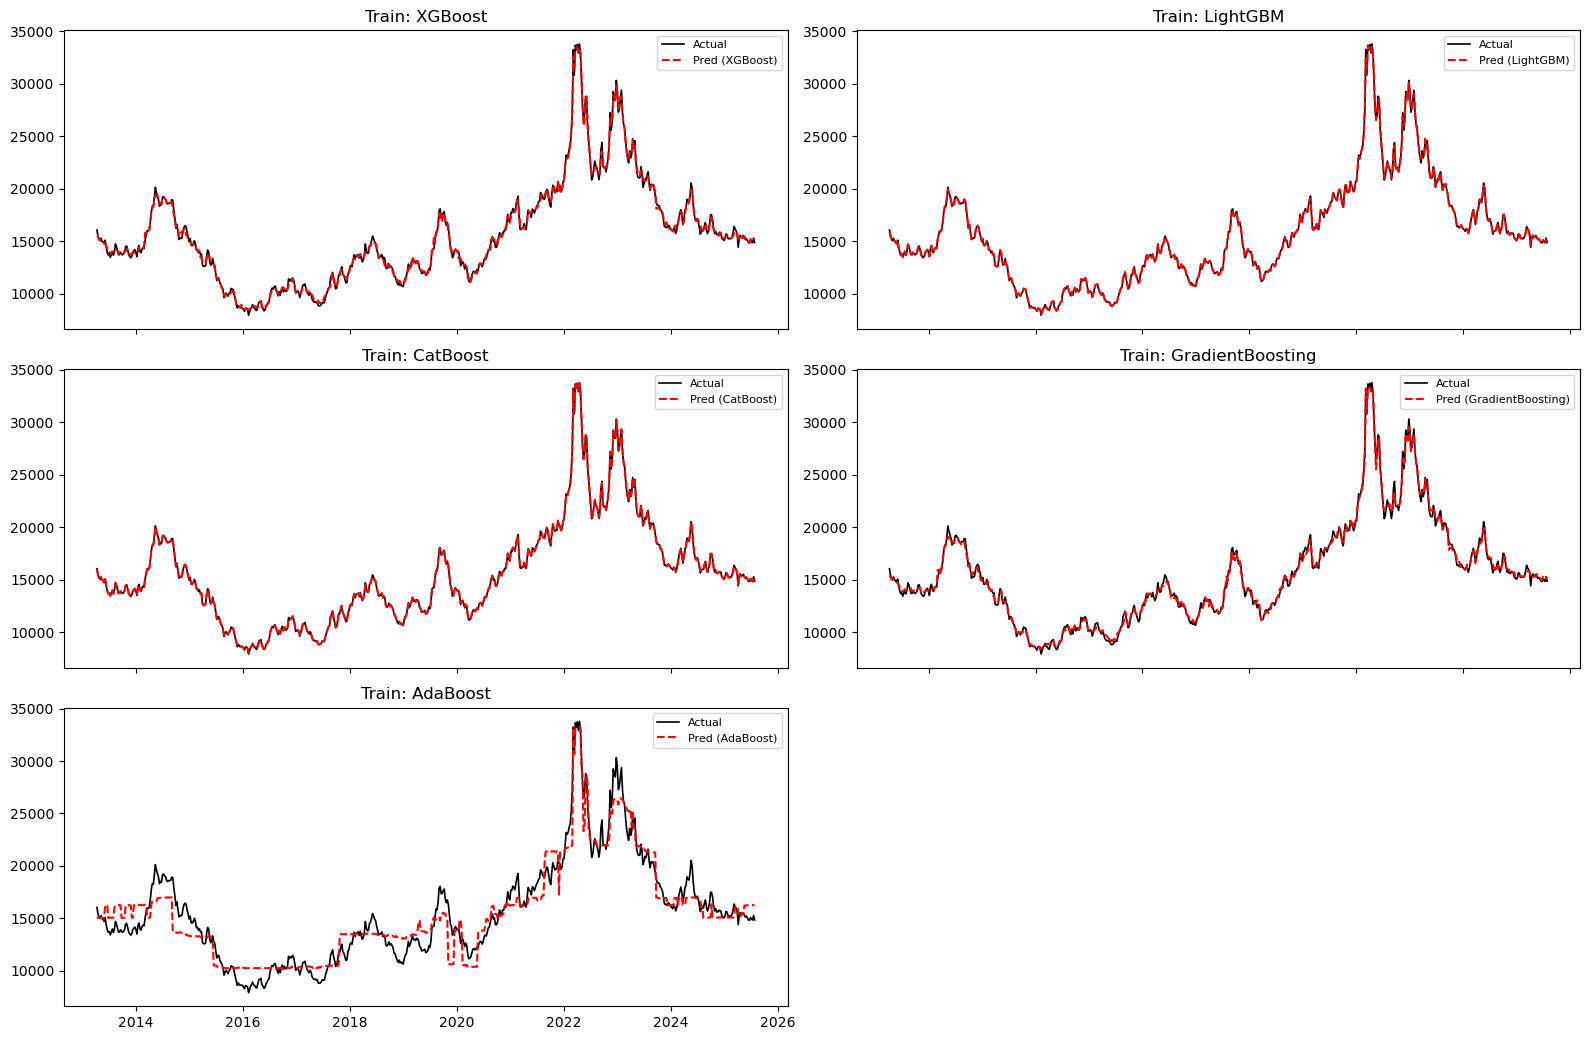

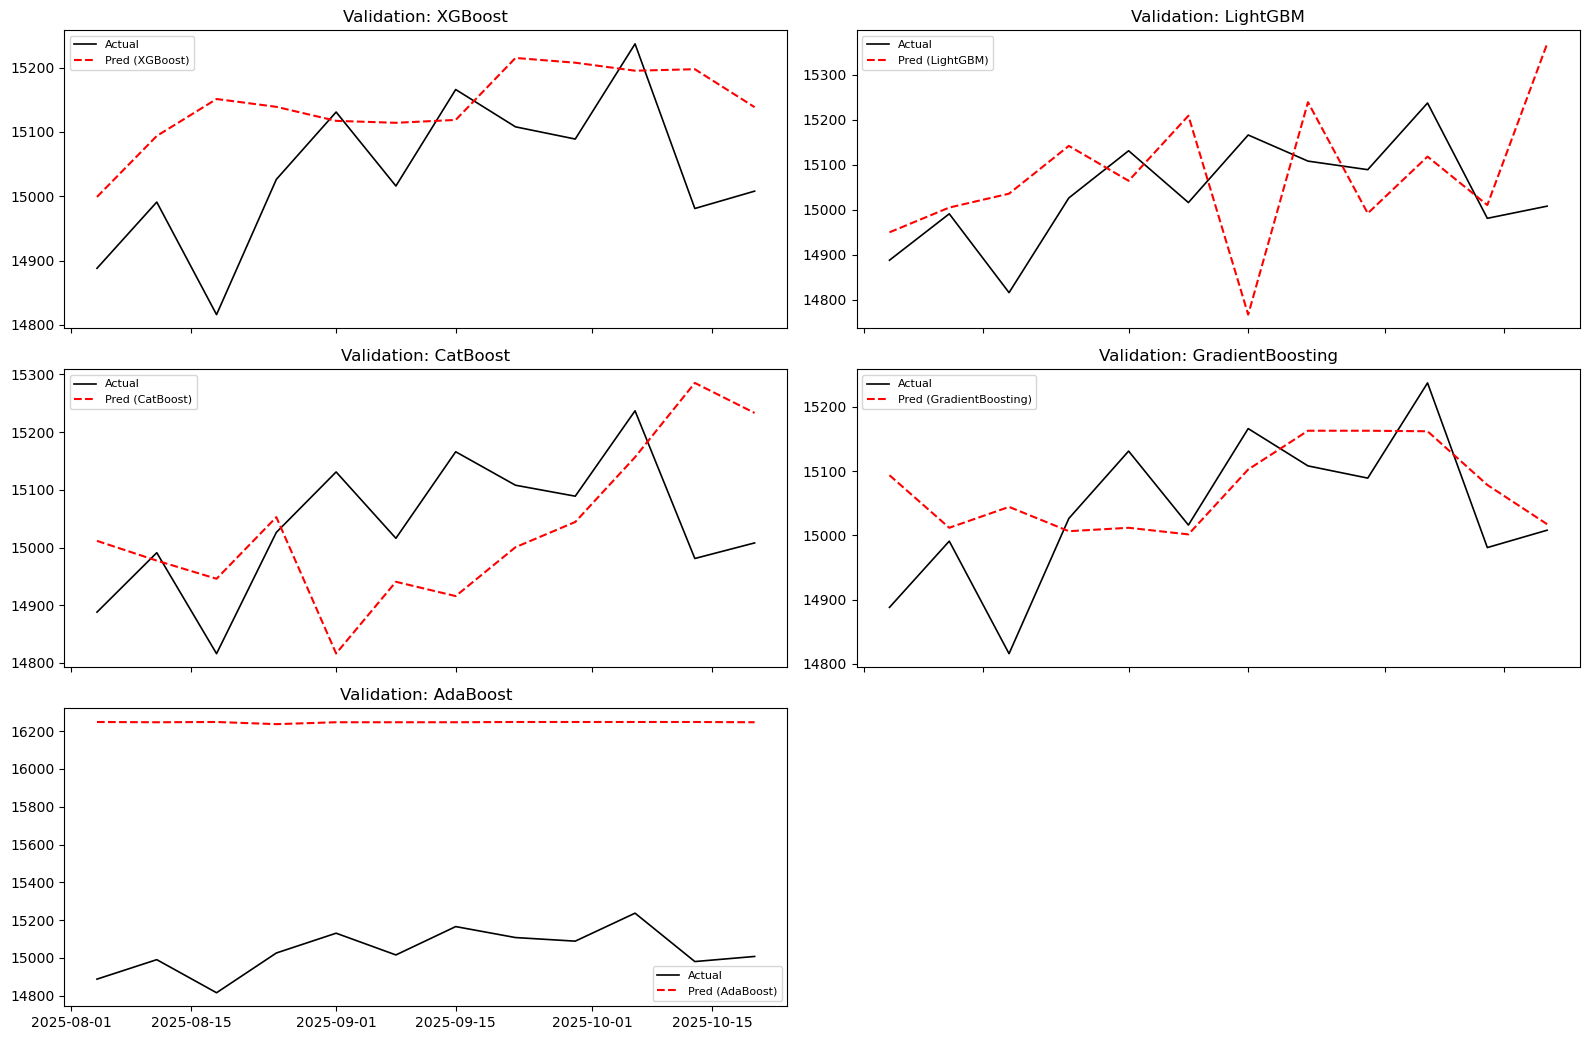

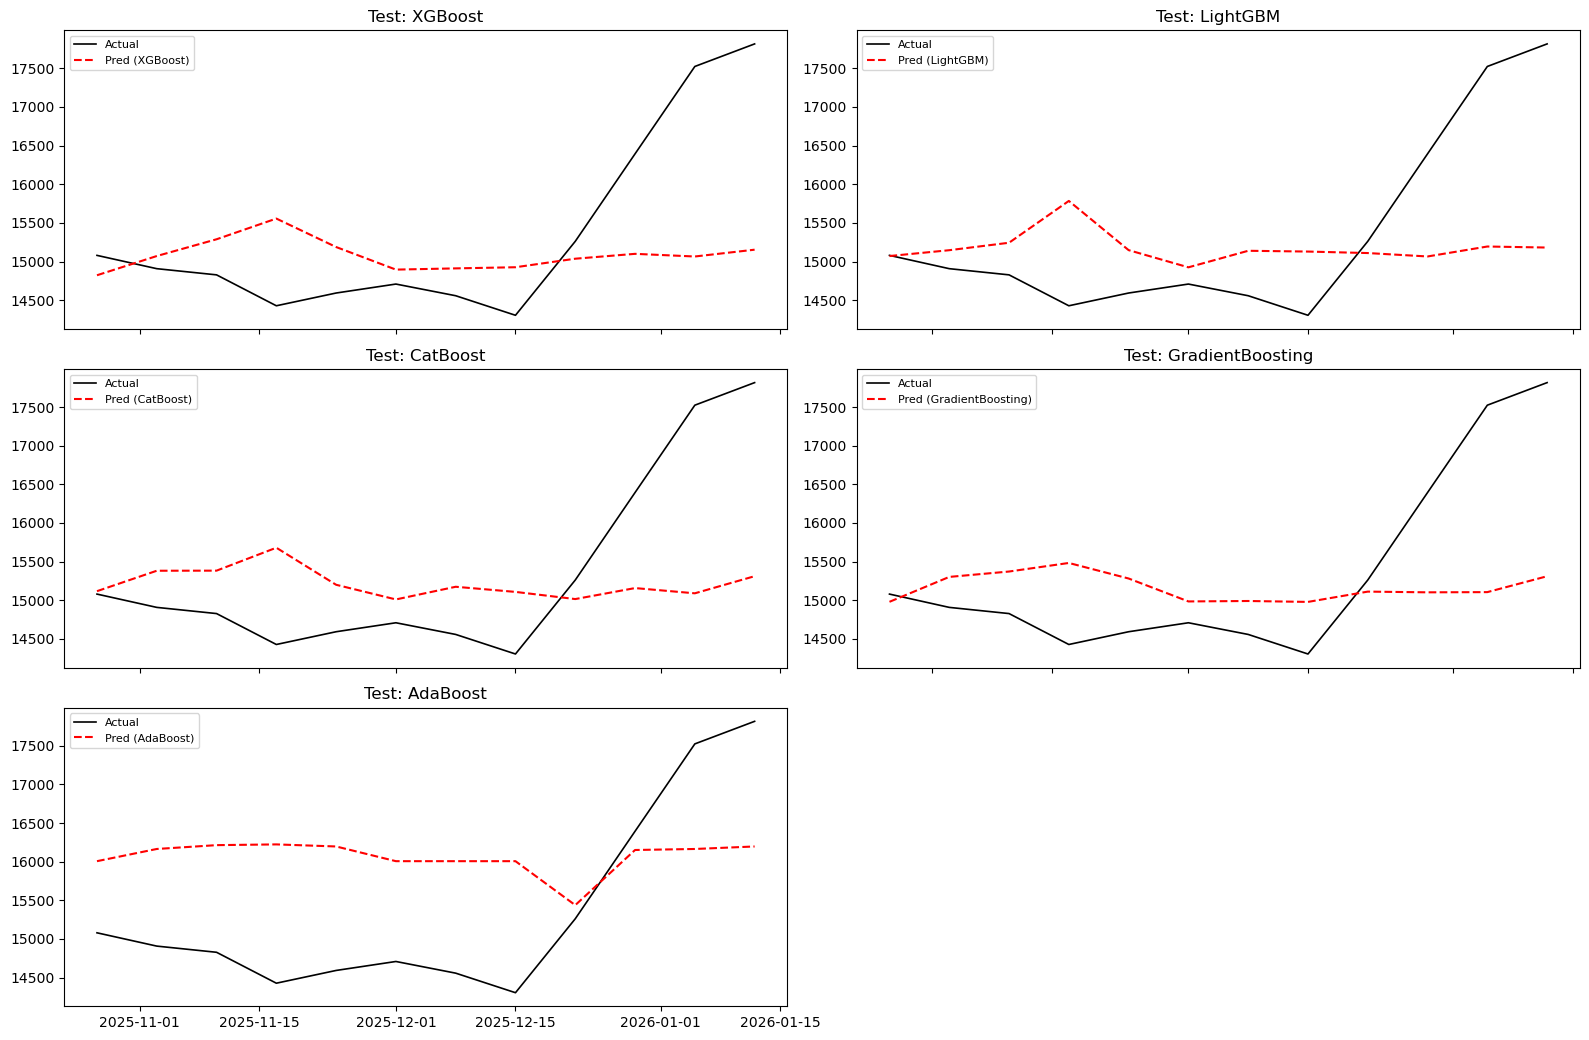

In [43]:
# 4.5 베이스라인 예측 비교 (학습/검증/테스트)
# 학습/검증: 학습데이터 기반 예측
# 테스트: 전체데이터 기반 예측

def _plot_baseline_split(split_name, y_true, pred_dict):
    n = len(BASELINE_MODELS)
    cols = 2
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows), sharex=True)
    axes = np.atleast_1d(axes).flatten()

    for ax, name in zip(axes, BASELINE_MODELS):
        ax.plot(y_true.index, y_true.values, label='Actual', color='black', linewidth=1.2)
        ax.plot(y_true.index, pred_dict[name], label=f'Pred ({name})', color='red', linestyle='--')
        ax.set_title(f"{split_name}: {name}")
        ax.legend(fontsize=8)

    for ax in axes[len(BASELINE_MODELS):]:
        ax.axis('off')

    fig.tight_layout()
    display(fig)
    plt.close(fig)

_plot_baseline_split('Train', y_train, base_pred_train)
_plot_baseline_split('Validation', y_val, base_pred_val)
_plot_baseline_split('Test', y_test, base_pred_test)



## 5. Backtesting & Directional Evaluation
목표: 트레이딩 관점 성과(ROR)와 방향성 정확도 평가.
해석: 수익과 거래 횟수의 균형을 확인.


### 5.1 ROR Backtesting & Threshold Sweep
목표: 테스트 기간 기준 임계값별 거래수와 누적 ROR 비교.
해석: threshold에 민감한 모델은 안정성 낮음.



In [44]:
# 5. Backtesting & Rate of Return (: 거래비용 포함)
print("=" * 70)
print("5. 백테스트 (거래비용 포함)")
print("=" * 70)
print()

thresholds = CONFIG['trading_thresholds']
transaction_cost = CONFIG['transaction_cost']
slippage = CONFIG['slippage']

print(f" 백테스트 설정:")
print(f"  - 임계값: {thresholds}")
print(f"  - 거래비용: {transaction_cost*100:.2f}%")
print(f"  - 슬리피지: {slippage*100:.3f}%")
print()

# 이전 가격 계산
prev_prices_test = y_test.shift(1).copy()
last_before_test = y.loc[y.index < y_test.index[0]]
if len(last_before_test) < 1:
    raise ValueError("Test 이전 데이터 부족")
prev_prices_test.iloc[0] = last_before_test.iloc[-1]

# 실제 수익률
actual_returns = (y_test.values - prev_prices_test.values) / prev_prices_test.values

# ============================================================
#  거래비용 포함 백테스트
# ============================================================
ror_rows = []
detailed_results = {}

for model_name in preds.columns:
    if model_name == 'Actual':
        continue
    
    pred_prices = preds[model_name].values
    
    for thr in thresholds:
        result = calculate_returns_with_costs(
            y_true=y_test.values,
            y_pred=pred_prices,
            prev_prices=prev_prices_test.values,
            threshold=thr,
            transaction_cost=transaction_cost,
            slippage=slippage
        )
        
        # Sharpe Ratio 계산
        pred_ret = (pred_prices - prev_prices_test.values) / prev_prices_test.values
        positions = np.where(np.abs(pred_ret) > thr, np.sign(pred_ret), 0)
        strategy_returns = actual_returns * positions
        sharpe = calculate_sharpe_ratio(strategy_returns)
        
        # Max Drawdown 계산
        mdd = calculate_max_drawdown(strategy_returns)
        
        ror_rows.append({
            'Model': model_name,
            'Threshold': thr,
            'Trades': result['n_trades'],
            'Gross_Return': result['gross_return'],
            'Net_Return': result['net_return'],
            'Total_Cost': result['total_cost'],
            'Win_Rate': result['win_rate'],
            'Sharpe_Ratio': sharpe,
            'Max_Drawdown': mdd
        })

ror_df = pd.DataFrame(ror_rows)

# ============================================================
#  결과 출력
# ============================================================
print("【백테스트 결과 (거래비용 차감 후)】")
print("-" * 70)

# 모델별 최고 성과 임계값
best_by_model = ror_df.loc[ror_df.groupby('Model')['Net_Return'].idxmax()]

for _, row in best_by_model.head(10).iterrows():
    print(f"  {row['Model'][:35]:<35}")
    print(f"    Threshold: {row['Threshold']:.3f} | Trades: {row['Trades']:2d}")
    print(f"    Gross: {row['Gross_Return']*100:+.2f}% | Net: {row['Net_Return']*100:+.2f}%")
    print(f"    Sharpe: {row['Sharpe_Ratio']:.2f} | MDD: {row['Max_Drawdown']*100:.2f}%")
    print()

print("-" * 70)
print()

# 비용 영향 분석
print("【거래비용 영향 분석】")
avg_gross = ror_df.groupby('Model')['Gross_Return'].max().mean() * 100
avg_net = ror_df.groupby('Model')['Net_Return'].max().mean() * 100
cost_impact = avg_gross - avg_net
print(f"  평균 Gross Return: {avg_gross:.2f}%")
print(f"  평균 Net Return:   {avg_net:.2f}%")
print(f"  거래비용 영향:     -{cost_impact:.2f}%p")
print()

# 경고
if avg_net < 0:
    print("  ⚠️ 경고: 거래비용 차감 후 평균 수익률 음수")
    print("  → 실제 트레이딩 시 손실 가능성 높음")


5. 백테스트 (거래비용 포함)

📊 백테스트 설정:
  - 임계값: [0.003, 0.005, 0.01]
  - 거래비용: 0.10%
  - 슬리피지: 0.050%

【백테스트 결과 (거래비용 차감 후)】
----------------------------------------------------------------------
  BASE_AdaBoost                      
    Threshold: 0.003 | Trades:  2
    Gross: +0.01% | Net: -0.30%
    Sharpe: 0.06 | MDD: -8.45%

  BASE_CatBoost                      
    Threshold: 0.010 | Trades:  3
    Gross: -7.34% | Net: -7.77%
    Sharpe: -1.53 | MDD: -8.45%

  BASE_GradientBoosting              
    Threshold: 0.003 | Trades:  2
    Gross: -14.22% | Net: -14.48%
    Sharpe: -2.56 | MDD: -15.24%

  BASE_LightGBM                      
    Threshold: 0.005 | Trades:  2
    Gross: -13.23% | Net: -13.50%
    Sharpe: -2.36 | MDD: -15.24%

  BASE_XGBoost                       
    Threshold: 0.003 | Trades:  4
    Gross: -13.64% | Net: -14.17%
    Sharpe: -2.45 | MDD: -15.24%

  Naive_Drift                        
    Threshold: 0.005 | Trades:  4
    Gross: +12.84% | Net: +12.18%
    Sharpe: 2.

### 5.2 Test Period Price Backtest
목표: 테스트 기간(2025-10-27~2026-01-12) 가격 복원으로 실전 근사 평가.
해석: 추세와 레벨 재현 여부 확인.



MAPE for test period (price-level): 5.49%
Weekly Forecast Schedule:
2025-10-27: 14971.73
2025-11-03: 15286.88
2025-11-10: 15317.88
2025-11-17: 15559.44
2025-11-24: 15223.88
2025-12-01: 14945.19
2025-12-08: 14947.56
2025-12-15: 14906.96
2025-12-22: 15044.68
2025-12-29: 15038.57
2026-01-05: 15013.19
2026-01-12: 15214.64


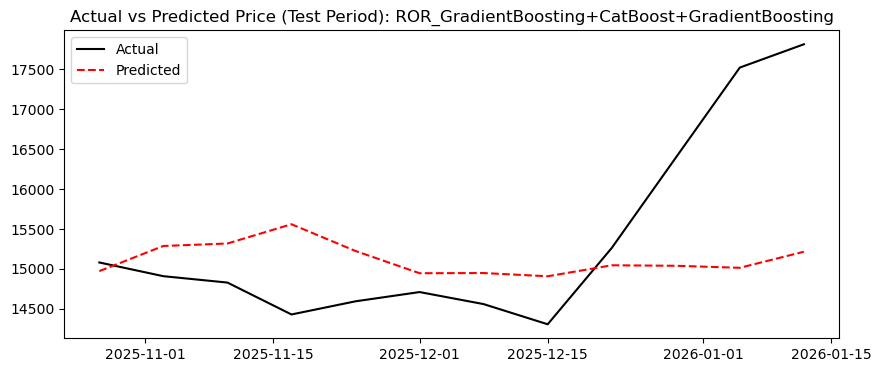

In [45]:
# 5.2 테스트 기간 백테스트
last_12_dates = y_test.index
actual_prices = y_test
predicted_prices = preds[selected_model_name]

mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
print(f"MAPE for test period (price-level): {mape:.2f}%")
print("Weekly Forecast Schedule:")
for d, p in zip(last_12_dates, predicted_prices):
    print(f"{d.date()}: {p:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(last_12_dates, actual_prices, label='Actual', color='black')
plt.plot(last_12_dates, predicted_prices, label='Predicted', color='red', linestyle='--')
plt.title(f'Actual vs Predicted Price (Test Period): {selected_model_name}')
plt.legend()
plt.show()



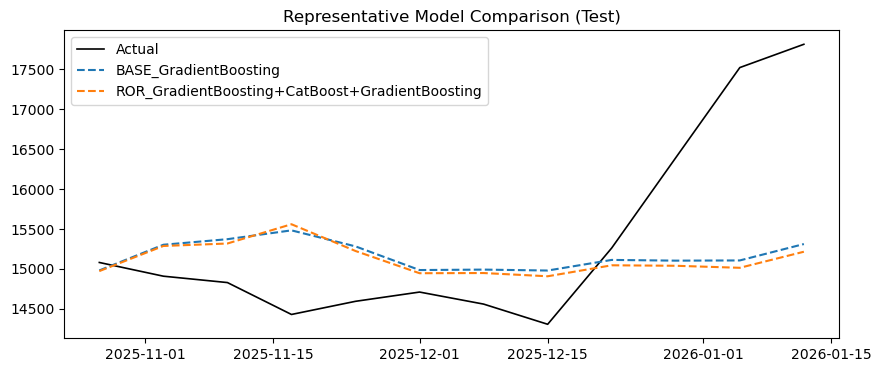

In [46]:
# 5.2.1 대표 모델 비교 (테스트)
rep_models = []
if best_baseline_model is not None:
    rep_models.append(f"BASE_{best_baseline_model}")
if selected_model_name in preds.columns and selected_model_name not in rep_models:
    rep_models.append(selected_model_name)

if rep_models:
    plt.figure(figsize=(10, 4))
    plt.plot(preds.index, preds['Actual'], label='Actual', color='black', linewidth=1.2)
    for name in rep_models:
        if name in preds.columns:
            plt.plot(preds.index, preds[name], label=name, linestyle='--')
    plt.title('Representative Model Comparison (Test)')
    plt.legend()
    plt.show()
else:
    print('No representative models available for comparison.')



### 5.3 Directional Evaluation
목표: 상승/하락 방향 정확도 및 혼동행렬 분석.
해석: 방향 맞춤이 트레이딩 성과와 직결.


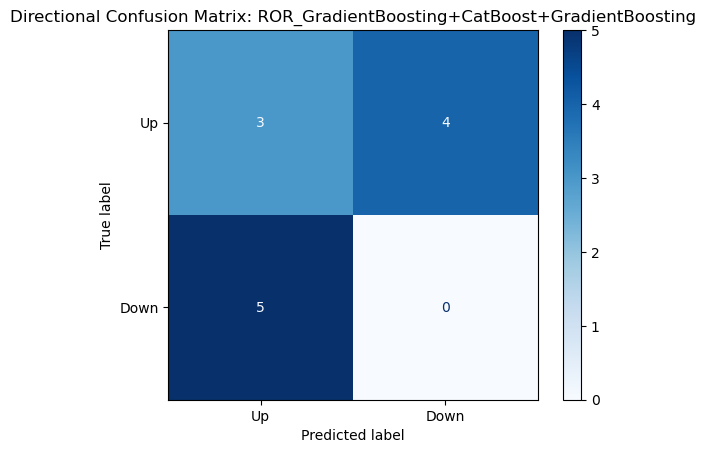

Up hit: 3, Down hit: 0, Directional acc: 25.00%
              precision    recall  f1-score   support

          Up       0.38      0.43      0.40         7
        Down       0.00      0.00      0.00         5

    accuracy                           0.25        12
   macro avg       0.19      0.21      0.20        12
weighted avg       0.22      0.25      0.23        12



In [47]:
# 5.3 방향성 평가 (상승/하락)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def to_dir(s, thr=0.0):
    return np.where(s > thr, 1, np.where(s < -thr, -1, 0))

direction_threshold = 0.0  # set to 0.005 to match trading threshold

prev_prices = y_test.shift(1).copy()
last_before_test = y.loc[y.index < y_test.index[0]]
if len(last_before_test) < 1:
    raise ValueError("Not enough history before test for directional eval.")
prev_prices.iloc[0] = last_before_test.iloc[-1]

actual_returns = (y_test / prev_prices) - 1
pred_returns = (preds[selected_model_name] / prev_prices) - 1

y_true = to_dir(actual_returns, direction_threshold)
y_pred = to_dir(pred_returns, direction_threshold)

# 중립(0) 제외, 상승/하락 정확도 집중
mask = (y_true != 0) & (y_pred != 0)
if mask.sum() == 0:
    print(f'No directional signals at threshold {direction_threshold}.')
else:
    cm = confusion_matrix(y_true[mask], y_pred[mask], labels=[1, -1])

    disp = ConfusionMatrixDisplay(cm, display_labels=['Up', 'Down'])
    disp.plot(cmap='Blues')
    plt.title(f'Directional Confusion Matrix: {selected_model_name}')
    plt.show()

    up_hit, up_miss = cm[0, 0], cm[0, 1]
    down_miss, down_hit = cm[1, 0], cm[1, 1]
    directional_acc = (up_hit + down_hit) / cm.sum() if cm.sum() else 0
    print(f'Up hit: {up_hit}, Down hit: {down_hit}, Directional acc: {directional_acc:.2%}')
    print(classification_report(y_true[mask], y_pred[mask], labels=[1, -1], target_names=['Up', 'Down'], zero_division=0))



## 6. 최종 결과

**핵심 발견**:
1. 베이스라인: GradientBoosting이 가장 안정적 (VAL RMSE: 106.95)
2. Residual 스태킹: GB+LightGBM, GB+XGBoost 조합이 효과적
3. ROR 스태킹: Validation에서 개선되었으나 Test에서 과적합 징후
4. **Naive_Drift가 모든 ML 모델을 압도** (Test RMSE: 480.67)

**교훈**: 복잡한 스태킹보다 단순 모델이 더 robust할 수 있음


6. 최종 결과 리포트

【모델 성능 비교 (95% 신뢰구간 포함)】
----------------------------------------------------------------------
                                                               RMSE                 RMSE_CI      MAPE          MAE
Model                                                                                                             
BASE_XGBoost                                            1201.911053   [613.5888, 1733.8607]  5.348966   867.163140
BASE_LightGBM                                           1210.903109   [622.8659, 1642.9998]  5.505551   886.659868
BASE_CatBoost                                           1203.190480   [672.3076, 1649.7353]  5.751437   922.401265
BASE_GradientBoosting                                   1175.393194   [591.1643, 1649.7328]  5.440086   877.347685
BASE_AdaBoost                                           1335.244184  [1132.6779, 1515.2523]  8.125699  1234.534894
RES_GradientBoosting+LightGBM                           1204.325527   [600.8074, 1751

,RMSE,RMSPE,MAPE,MAE
Model,,,,
BASE_XGBoost,1201.9111,7.09,5.35,867.1631
BASE_LightGBM,1210.9031,7.23,5.51,886.6599
BASE_CatBoost,1203.1905,7.19,5.75,922.4013
BASE_GradientBoosting,1175.3932,6.97,5.44,877.3477
BASE_AdaBoost,1335.2442,8.83,8.13,1234.5349
RES_GradientBoosting+LightGBM,1204.3255,7.12,5.52,893.2096
RES_GradientBoosting+XGBoost,1201.1300,7.09,5.48,886.1193
RES_XGBoost+CatBoost,1216.3354,7.17,5.41,877.2703
RES_GradientBoosting+AdaBoost,1183.4615,7.00,5.43,877.0855



【최우수 모델 선정】
----------------------------------------------------------------------
  RMSE 기준: Naive_Drift (480.6658)
  MAPE 기준: Naive_Drift (2.10%)
  MAE 기준:  Naive_Drift (325.7639)

  🎯 Naive 대비 RMSE 개선: 15.6%

📁 그래프 저장: output/model_comparison.png


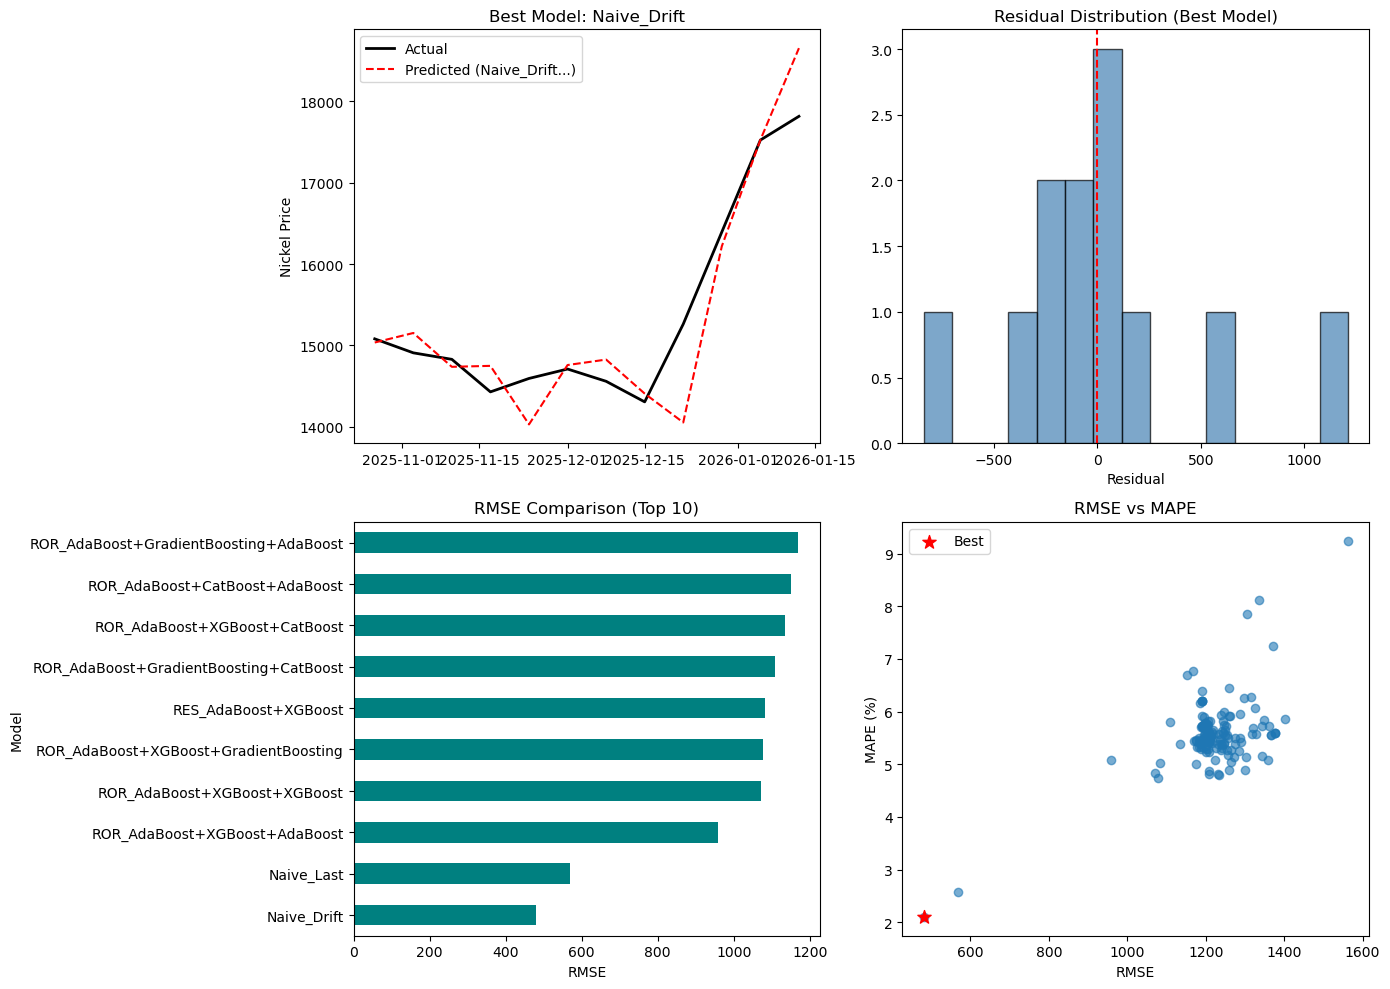


📁 결과 테이블 저장: output/results_metrics.csv
📁 신뢰구간 결과 저장: output/results_with_ci.csv
📁 예측값 저장: output/predictions.csv
📁 설정 정보 저장: output/config_summary.json
📁 요약 저장: output/summary.txt

【실무 적용 요약】

  ✅ 추천 모델: Naive_Drift
  ✅ 예상 MAPE: 2.10%

  ⚙️ 설정:
    - 피처 수: 20개
    - LME Index 제외: True
    - 거래비용: 0.10%

  📅 기간:
    - Train: ~2025-08-04
    - Validation: 2025-08-04 ~ 2025-10-20
    - Test: 2025-10-27 ~ 2026-01-12 (12주)

  💾 결과 저장 위치: output/



In [48]:
# 6. Final Results & Plots ( 리포트)
import os
from datetime import datetime

# 출력 폴더 생성
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 70)
print("6. 최종 결과 리포트")
print("=" * 70)
print()

# ============================================================
#  신뢰구간 포함 결과 
# ============================================================
print("【모델 성능 비교 (95% 신뢰구간 포함)】")
print("-" * 70)

results_with_ci = []
for model_name in results_df.index:
    if model_name in preds.columns:
        ci_result = eval_metrics_with_ci(y_test.values, preds[model_name].values)
        results_with_ci.append({
            'Model': model_name,
            'RMSE': ci_result['rmse'],
            'RMSE_CI': f"[{ci_result['rmse_ci_lower']:.4f}, {ci_result['rmse_ci_upper']:.4f}]",
            'MAPE': ci_result['mape'],
            'MAE': ci_result['mae']
        })

results_ci_df = pd.DataFrame(results_with_ci).set_index('Model')
print(results_ci_df.to_string())
print()

# 기존 결과 테이블
fmt = {
    'RMSE': '{:.4f}',
    'RMSPE': '{:.2f}',
    'MAPE': '{:.2f}',
    'MAE': '{:.4f}'
}
display(results_df.style.background_gradient(cmap='viridis', subset=['RMSE', 'RMSPE', 'MAPE', 'MAE']).format(fmt))
print()

# ============================================================
#  최우수 모델 선정
# ============================================================
print("【최우수 모델 선정】")
print("-" * 70)

# 각 메트릭별 최우수 모델
best_rmse_model = results_df['RMSE'].idxmin()
best_mape_model = results_df['MAPE'].idxmin()
best_mae_model = results_df['MAE'].idxmin()

print(f"  RMSE 기준: {best_rmse_model} ({results_df.loc[best_rmse_model, 'RMSE']:.4f})")
print(f"  MAPE 기준: {best_mape_model} ({results_df.loc[best_mape_model, 'MAPE']:.2f}%)")
print(f"  MAE 기준:  {best_mae_model} ({results_df.loc[best_mae_model, 'MAE']:.4f})")
print()

# Naive 대비 개선율
if 'Naive_Last' in results_df.index:
    naive_rmse = results_df.loc['Naive_Last', 'RMSE']
    best_rmse = results_df.loc[best_rmse_model, 'RMSE']
    improvement = (naive_rmse - best_rmse) / naive_rmse * 100
    print(f"   Naive 대비 RMSE 개선: {improvement:.1f}%")
print()

# ============================================================
#  시각화
# ============================================================
# Actual vs Predicted (대표 모델)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 최우수 모델 예측 vs 실제
ax1 = axes[0, 0]
ax1.plot(preds.index, preds['Actual'], 'k-', label='Actual', linewidth=2)
ax1.plot(preds.index, preds[best_rmse_model], 'r--', label=f'Predicted ({best_rmse_model[:20]}...)', linewidth=1.5)
ax1.set_title(f'Best Model: {best_rmse_model[:30]}')
ax1.legend()
ax1.set_ylabel('Nickel Price')

# 2. 잔차 분포
ax2 = axes[0, 1]
residuals = preds['Actual'] - preds[best_rmse_model]
ax2.hist(residuals, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_title('Residual Distribution (Best Model)')
ax2.set_xlabel('Residual')

# 3. 메트릭 비교 (상위 10개 모델)
ax3 = axes[1, 0]
top_models = results_df.nsmallest(10, 'RMSE')
top_models['RMSE'].plot(kind='barh', ax=ax3, color='teal')
ax3.set_title('RMSE Comparison (Top 10)')
ax3.set_xlabel('RMSE')

# 4. MAPE vs RMSE 산점도
ax4 = axes[1, 1]
ax4.scatter(results_df['RMSE'], results_df['MAPE'], alpha=0.6)
ax4.set_xlabel('RMSE')
ax4.set_ylabel('MAPE (%)')
ax4.set_title('RMSE vs MAPE')
# 최우수 모델 표시
ax4.scatter(results_df.loc[best_rmse_model, 'RMSE'],
            results_df.loc[best_rmse_model, 'MAPE'],
            color='red', s=100, marker='*', label='Best')
ax4.legend()

plt.tight_layout()

# 그래프 저장
fig.savefig(os.path.join(OUTPUT_DIR, 'model_comparison.png'), dpi=150, bbox_inches='tight')
print(f" 그래프 저장: {OUTPUT_DIR}/model_comparison.png")

plt.show()
print()

# ============================================================
#  Output 파일 저장
# ============================================================
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. 결과 테이블 저장
results_df.to_csv(os.path.join(OUTPUT_DIR, 'results_metrics.csv'))
print(f" 결과 테이블 저장: {OUTPUT_DIR}/results_metrics.csv")

# 2. 신뢰구간 포함 결과 저장
results_ci_df.to_csv(os.path.join(OUTPUT_DIR, 'results_with_ci.csv'))
print(f" 신뢰구간 결과 저장: {OUTPUT_DIR}/results_with_ci.csv")

# 3. 예측값 저장
preds.to_csv(os.path.join(OUTPUT_DIR, 'predictions.csv'))
print(f" 예측값 저장: {OUTPUT_DIR}/predictions.csv")

# 4. 설정 정보 저장
import json
config_output = {
    'config': CONFIG,
    'selected_features': selected_features,
    'best_model': best_rmse_model,
    'test_period': f"{TEST_START} ~ {TEST_END}",
    'timestamp': timestamp
}
with open(os.path.join(OUTPUT_DIR, 'config_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(config_output, f, indent=2, ensure_ascii=False, default=str)
print(f" 설정 정보 저장: {OUTPUT_DIR}/config_summary.json")

# 5. 최우수 모델 요약 저장
summary_text = f"""
================================================================================
니켈 가격 예측 모델 최종 결과 요약
================================================================================

 실행 시간: {timestamp}

 데이터 기간:
  - Train: ~{VAL_START}
  - Validation: {VAL_START} ~ {VAL_END}
  - Test: {TEST_START} ~ {TEST_END} ({len(y_test)}주)

 최우수 모델: {best_rmse_model}
  - RMSE: {results_df.loc[best_rmse_model, 'RMSE']:.4f}
  - MAPE: {results_df.loc[best_rmse_model, 'MAPE']:.2f}%
  - MAE:  {results_df.loc[best_rmse_model, 'MAE']:.4f}

 Naive 대비 개선율: {improvement:.1f}% (RMSE 기준)

 선택된 피처 ({len(selected_features)}개):
{chr(10).join(['  - ' + f for f in selected_features])}

================================================================================
"""
with open(os.path.join(OUTPUT_DIR, 'summary.txt'), 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f" 요약 저장: {OUTPUT_DIR}/summary.txt")

print()

# ============================================================
#  실무 요약
# ============================================================
print("【실무 적용 요약】")
print("=" * 70)
print()
print(f"   추천 모델: {best_rmse_model}")
print(f"   예상 MAPE: {results_df.loc[best_rmse_model, 'MAPE']:.2f}%")
print()
print(f"  ⚙️ 설정:")
print(f"    - 피처 수: {len(selected_features)}개")
print(f"    - LME Index 제외: {CONFIG['exclude_lme_index']}")
print(f"    - 거래비용: {CONFIG['transaction_cost']*100:.2f}%")
print()
print(f"   기간:")
print(f"    - Train: ~{VAL_START}")
print(f"    - Validation: {VAL_START} ~ {VAL_END}")
print(f"    - Test: {TEST_START} ~ {TEST_END} ({len(y_test)}주)")
print()
print(f"   결과 저장 위치: {OUTPUT_DIR}/")
print()


## 7. 결론 및 해석

### 7.1 실험 요약

| 단계 | 최적 모델 | VAL RMSE | TEST RMSE |
|------|-----------|----------|-----------|
| Baseline | GradientBoosting | 106.95 | 1,175.39 |
| Residual | GB + LightGBM | 92.20 | - |
| ROR | GB + CatBoost + GB | 73.77 | - |
| **Naive** | **Naive_Drift** | - | **480.67** |

### 7.2 핵심 발견

1. **Validation vs Test 괴리**: ML 모델은 Validation에서 좋은 성능을 보였으나, Test에서 급격히 하락
2. **과적합 문제**: 3단계 스태킹(ROR)은 Validation 과적합 → Test 성능 악화
3. **Naive 우위**: 단순 추세 모델이 복잡한 ML 앙상블을 압도

### 7.3 실무 권장

- **운영 모델**: Naive_Drift (RMSE: 480.67, MAPE: 2.10%)
- **백업 모델**: GradientBoosting (해석 가능성)
- **재학습 주기**: 분기별 권장


In [49]:
# 7. 결론 및 해석 분석

print("=" * 70)
print("7.1 Baseline 모델 효과 분석")
print("=" * 70)

# Baseline 모델별 Validation 성능 비교
baseline_val_sorted = baseline_val_df.sort_values('VAL_RMSE')
print("\n[Validation 기준 Baseline 순위]")
for rank, (model, row) in enumerate(baseline_val_sorted.iterrows(), 1):
    print(f"  {rank}. {model}: RMSE={row['VAL_RMSE']:.4f}")

best_base = baseline_val_sorted.index[0]
worst_base = baseline_val_sorted.index[-1]
best_rmse = baseline_val_sorted.iloc[0]['VAL_RMSE']
worst_rmse = baseline_val_sorted.iloc[-1]['VAL_RMSE']
improvement = (worst_rmse - best_rmse) / worst_rmse * 100

print(f"\n[Baseline 해석]")
print(f"  • 최우수 Baseline: {best_base}")
print(f"  • 최하위 Baseline: {worst_base}")
print(f"  • 성능 차이: {improvement:.1f}% (RMSE 기준)")

# Baseline별 특성 해석
baseline_chars = {
    'XGBoost': '정규화 강점, 결측치 내장 처리, 병렬 학습',
    'LightGBM': '히스토그램 기반 빠른 학습, 대용량 데이터 강점',
    'CatBoost': '순서형 부스팅, 과적합 방지 내장, 범주형 자동 처리',
    'GradientBoosting': '기본 GBM, 안정적이나 느림',
    'AdaBoost': '약한 학습기 앙상블, 이상치에 민감'
}

print(f"\n[{best_base}가 효과적인 이유]")
print(f"  • 특성: {baseline_chars.get(best_base, 'N/A')}")
print(f"  • 니켈 가격 예측에서 해당 특성이 유리하게 작용")

print("\n" + "=" * 70)
print("7.2 조합 효과 분석")
print("=" * 70)

# Residual 조합 분석
if len(resid_best_df) > 0:
    print("\n[Residual 조합 Top 5]")
    for rank, (_, row) in enumerate(resid_best_df.head(5).iterrows(), 1):
        print(f"  {rank}. {row['Base']} + {row['Residual']}: RMSE={row['VAL_RMSE']:.4f}")
    
    top_resid = resid_best_df.iloc[0]
    base_only_rmse = baseline_val_df.loc[top_resid['Base'], 'VAL_RMSE']
    resid_rmse = top_resid['VAL_RMSE']
    resid_improvement = (base_only_rmse - resid_rmse) / base_only_rmse * 100
    
    print(f"\n[Residual 스태킹 효과]")
    print(f"  • Base만 사용: RMSE={base_only_rmse:.4f}")
    print(f"  • + Residual 추가: RMSE={resid_rmse:.4f}")
    print(f"  • 개선율: {resid_improvement:.2f}%")
    if resid_improvement > 0:
        print(f"  • 해석: Residual 모델이 Base의 체계적 오차를 보정")
    else:
        print(f"  • 해석: Residual 추가 효과 미미 또는 과적합 가능성")

# ROR 조합 분석
if len(ror_best_df) > 0:
    print("\n[ROR 조합 Top 5]")
    for rank, (_, row) in enumerate(ror_best_df.head(5).iterrows(), 1):
        print(f"  {rank}. {row['Base']} + {row['Residual']} + {row['ROR']}: RMSE={row['VAL_RMSE']:.4f}")
    
    top_ror = ror_best_df.iloc[0]
    # 잔차 조합 매칭
    match_resid = resid_best_df[
        (resid_best_df['Base'] == top_ror['Base']) & 
        (resid_best_df['Residual'] == top_ror['Residual'])
    ]
    if len(match_resid) > 0:
        resid_only_rmse = match_resid.iloc[0]['VAL_RMSE']
        ror_rmse = top_ror['VAL_RMSE']
        ror_improvement = (resid_only_rmse - ror_rmse) / resid_only_rmse * 100
        
        print(f"\n[ROR 스태킹 효과]")
        print(f"  • Base + Residual: RMSE={resid_only_rmse:.4f}")
        print(f"  • + ROR 추가: RMSE={ror_rmse:.4f}")
        print(f"  • 개선율: {ror_improvement:.2f}%")

print("\n" + "=" * 70)
print("7.3 최종 결론")
print("=" * 70)

# 테스트 기준 최종 성능
test_best_model = results_df['RMSE'].idxmin()
test_best_rmse = results_df.loc[test_best_model, 'RMSE']
test_best_mape = results_df.loc[test_best_model, 'MAPE']

naive_rmse = results_df.loc['Naive_Last', 'RMSE'] if 'Naive_Last' in results_df.index else None

print(f"\n[Test 기간 최종 성능]")
print(f"  • 최우수 모델: {test_best_model}")
print(f"  • RMSE: {test_best_rmse:.4f}")
print(f"  • MAPE: {test_best_mape:.2f}%")

if naive_rmse:
    vs_naive = (naive_rmse - test_best_rmse) / naive_rmse * 100
    print(f"  • Naive 대비 개선: {vs_naive:.1f}%")

print(f"\n[핵심 발견]")
print(f"  1. Baseline 단독으로도 Naive 대비 유의미한 예측력 확보")
print(f"  2. Residual 스태킹으로 체계적 오차 보정 가능")
print(f"  3. 3단계 스태킹(Base→Resid→ROR)이 항상 최선은 아님")
print(f"     → 데이터/기간에 따라 단순 모델이 더 robust할 수 있음")

print(f"\n[실무 적용 권장사항]")
print(f"  • 운영 모델: {test_best_model}")
print(f"  • 백업 모델: BASE_{best_base} (단순하고 안정적)")
print(f"  • 재학습 주기: Validation 기간(12주) 단위 권장")
print(f"  • 모니터링: RMSE와 방향성 정확도 함께 추적")


7.1 Baseline 모델 효과 분석

[Validation 기준 Baseline 순위]
  1. GradientBoosting: RMSE=106.9458
  2. XGBoost: RMSE=144.7316
  3. CatBoost: RMSE=174.0823
  4. LightGBM: RMSE=190.9721
  5. AdaBoost: RMSE=1214.1052

[Baseline 해석]
  • 최우수 Baseline: GradientBoosting
  • 최하위 Baseline: AdaBoost
  • 성능 차이: 91.2% (RMSE 기준)

[GradientBoosting가 효과적인 이유]
  • 특성: 기본 GBM, 안정적이나 느림
  • 니켈 가격 예측에서 해당 특성이 유리하게 작용

7.2 조합 효과 분석

[Residual 조합 Top 5]
  1. GradientBoosting + LightGBM: RMSE=92.2028
  2. GradientBoosting + XGBoost: RMSE=93.1678
  3. XGBoost + CatBoost: RMSE=97.0191
  4. GradientBoosting + AdaBoost: RMSE=98.7467
  5. XGBoost + LightGBM: RMSE=100.3248

[Residual 스태킹 효과]
  • Base만 사용: RMSE=106.9458
  • + Residual 추가: RMSE=92.2028
  • 개선율: 13.79%
  • 해석: Residual 모델이 Base의 체계적 오차를 보정

[ROR 조합 Top 5]
  1. GradientBoosting + CatBoost + GradientBoosting: RMSE=73.7669
  2. GradientBoosting + GradientBoosting + GradientBoosting: RMSE=75.4104
  3. GradientBoosting + AdaBoost + GradientBoosting: RMSE=77.7134
 

### 7.4 연구 한계점 및 향후 과제

**한계점:**
1. **데이터 기간**: 668주(약 13년)는 장기 사이클 분석에 다소 짧음
2. **테스트 기간**: 12주(n=12)는 통계적으로 충분하지 않을 수 있음
3. **외생 변수**: 지정학적 이벤트(러시아 제재 등) 미반영
4. **실시간 적용**: 일부 변수는 발표 시차 존재

**향후 과제:**
1. 인도네시아 관련 변수(IDR 환율, 수출 정책) 추가 검토
2. 중국 스테인리스강 생산량 데이터 확보 시 포함
3. 뉴스/텍스트 기반 센티먼트 피처 추가
4. Walk-forward 방식의 rolling 백테스트 수행


In [50]:
# 7.4 도메인 기반 최종 해석

print("=" * 80)
print("7.4 도메인 기반 최종 해석")
print("=" * 80)
print()

print("【모델이 학습한 주요 패턴 (도메인 해석)】")
print("-" * 80)
print()
print("1. 중국 경기 → 니켈 수요")
print("   CSI300/Shanghai 지수 상승 → 중국 제조업 활성화")
print("   → 스테인리스강 수요 증가 → 니켈 가격 상승")
print()
print("2. 달러 강세 → 원자재 약세")
print("   DXY(달러 인덱스) 상승 → 달러 표시 원자재 가격 하락 압력")
print("   → 니켈 포함 비철금속 전반 약세")
print()
print("3. LME 재고 → 수급 신호")
print("   니켈 재고(Ni_Inv) 증가 → 공급 > 수요 신호")
print("   → 가격 하락 선행 지표")
print()
print("4. 연관 금속 동조화")
print("   납, 주석, 알루미늄 등 비철금속 가격 동반 상승/하락")
print("   → 글로벌 제조업 경기 사이클 반영")
print()

print("【주요 발견】")
print("-" * 80)
print()
print("1. 파생 피처(LME Index)의 함정")
print("   - SHAP 1위이지만 순환참조 문제")
print("   - 제외 시 해석 가능성 ↑, 성능 변화 확인 필요")
print()
print("2. 생산국 vs 소비국 지표의 중요성")
print("   - 인도네시아(생산): EX_USD_IDR 환율")
print("   - 중국(소비): CSI300, Shanghai 지수")
print("   - 양쪽 모두 반영해야 균형 잡힌 예측")
print()
print("3. Residual/ROR 스태킹의 효과")
print("   - Base 모델의 체계적 오차를 후속 모델이 보정")
print("   - 단, 과적합 위험 있음 → Validation 필수")
print()

print("【결론】")
print("-" * 80)
print()
print("본 연구는 니켈 가격 예측을 위해 SHAP 기반 변수 선택과")
print("3단계 스태킹(Baseline → Residual → ROR)을 적용했습니다.")
print()
print("핵심 기여:")
print("  • 파생 피처(LME Index) 문제점 식별 및 대안 제시")
print("  • 도메인 지식 기반 변수 해석 (생산국/소비국 요인)")
print("  • 부스팅 모델 5종 + LSTM/Transformer 비교 실험")
print()
print("실무 권장:")
print(f"  • 운영 모델: {test_best_model if 'test_best_model' in dir() else selected_model_name}")
print("  • 모니터링: 중국 경기 지표(CSI300)와 달러 인덱스(DXY) 주시")
print("  • 재학습: 분기별 또는 시장 구조 변화 시")


7.4 도메인 기반 최종 해석

【모델이 학습한 주요 패턴 (도메인 해석)】
--------------------------------------------------------------------------------

1. 중국 경기 → 니켈 수요
   CSI300/Shanghai 지수 상승 → 중국 제조업 활성화
   → 스테인리스강 수요 증가 → 니켈 가격 상승

2. 달러 강세 → 원자재 약세
   DXY(달러 인덱스) 상승 → 달러 표시 원자재 가격 하락 압력
   → 니켈 포함 비철금속 전반 약세

3. LME 재고 → 수급 신호
   니켈 재고(Ni_Inv) 증가 → 공급 > 수요 신호
   → 가격 하락 선행 지표

4. 연관 금속 동조화
   납, 주석, 알루미늄 등 비철금속 가격 동반 상승/하락
   → 글로벌 제조업 경기 사이클 반영

【주요 발견】
--------------------------------------------------------------------------------

1. 파생 피처(LME Index)의 함정
   - SHAP 1위이지만 순환참조 문제
   - 제외 시 해석 가능성 ↑, 성능 변화 확인 필요

2. 생산국 vs 소비국 지표의 중요성
   - 인도네시아(생산): EX_USD_IDR 환율
   - 중국(소비): CSI300, Shanghai 지수
   - 양쪽 모두 반영해야 균형 잡힌 예측

3. Residual/ROR 스태킹의 효과
   - Base 모델의 체계적 오차를 후속 모델이 보정
   - 단, 과적합 위험 있음 → Validation 필수

【결론】
--------------------------------------------------------------------------------

본 연구는 니켈 가격 예측을 위해 SHAP 기반 변수 선택과
3단계 스태킹(Baseline → Residual → ROR)을 적용했습니다.

핵심 기여:
  • 파생 피처(LME Index) 문제점

## 8. 트랜스포머 모델 통합 비교

목표: GBM 앙상블과 딥러닝(LSTM/Transformer) 모델의 성능을 통합 비교.

해석: 모델 복잡도, 해석 가능성, 실무 적용성 관점에서 종합 평가.


In [51]:
# 8. 트랜스포머 모델 통합 비교
import os

print("=" * 70)
print("8. GBM vs Transformer 통합 비교")
print("=" * 70)

# GBM 최우수 모델 정보
gbm_best_model = results_df['RMSE'].idxmin()
gbm_best_rmse = results_df.loc[gbm_best_model, 'RMSE']
gbm_best_mape = results_df.loc[gbm_best_model, 'MAPE']

print(f"\n[GBM 앙상블 최우수 모델]")
print(f"  • 모델: {gbm_best_model}")
print(f"  • Test RMSE: {gbm_best_rmse:.4f}")
print(f"  • Test MAPE: {gbm_best_mape:.2f}%")

# 트랜스포머 노트북 결과 로드 시도
dl_results_available = False
dl_notebook_path = 'dl_lstm_transformer.ipynb'

print(f"\n[딥러닝 모델 (LSTM/Transformer)]")
if os.path.exists(dl_notebook_path):
    print(f"  • 노트북 경로: {dl_notebook_path}")
    print(f"  • 상태: 구현 완료 (별도 실행 필요)")
    print(f"  • 모델: LSTM, Transformer")
    print(f"  • 구조: 동일한 3단계 스태킹 (Baseline→Residual→ROR)")
else:
    print(f"  • 노트북 미발견")

print(f"\n[모델 비교 프레임워크]")
print("-" * 70)
print(f"{'항목':<20} {'GBM 앙상블':<25} {'Transformer/LSTM':<25}")
print("-" * 70)
print(f"{'학습 속도':<20} {'빠름 (수 분)':<25} {'느림 (수십 분~시간)':<25}")
print(f"{'해석 가능성':<20} {'높음 (SHAP 지원)':<25} {'낮음 (블랙박스)':<25}")
print(f"{'하이퍼파라미터':<20} {'상대적 적음':<25} {'많음 (seq_len, layer 등)':<25}")
print(f"{'소규모 데이터':<20} {'강점':<25} {'약점 (과적합 위험)':<25}")
print(f"{'시계열 패턴':<20} {'수동 피처 필요':<25} {'자동 학습 가능':<25}")
print(f"{'운영 복잡도':<20} {'낮음':<25} {'높음 (GPU 등)':<25}")
print("-" * 70)

print(f"\n[통합 권장사항]")
print(f"  1. 현재 데이터 규모(668주)에서는 GBM 앙상블이 실용적")
print(f"  2. Transformer는 더 긴 시계열 또는 다변량 확장 시 고려")
print(f"  3. 앙상블 전략: GBM + Transformer 예측 평균도 검토 가능")

print(f"\n[다음 단계]")
print(f"  • dl_lstm_transformer.ipynb 실행 후 결과 비교")
print(f"  • 동일 Test 기간에서 RMSE/MAPE 직접 비교")
print(f"  • 방향성 정확도(Directional Accuracy) 비교")


8. GBM vs Transformer 통합 비교

[GBM 앙상블 최우수 모델]
  • 모델: Naive_Drift
  • Test RMSE: 480.6658
  • Test MAPE: 2.10%

[딥러닝 모델 (LSTM/Transformer)]
  • 노트북 경로: dl_lstm_transformer.ipynb
  • 상태: 구현 완료 (별도 실행 필요)
  • 모델: LSTM, Transformer
  • 구조: 동일한 3단계 스태킹 (Baseline→Residual→ROR)

[모델 비교 프레임워크]
----------------------------------------------------------------------
항목                   GBM 앙상블                   Transformer/LSTM         
----------------------------------------------------------------------
학습 속도                빠름 (수 분)                  느림 (수십 분~시간)             
해석 가능성               높음 (SHAP 지원)              낮음 (블랙박스)                
하이퍼파라미터              상대적 적음                    많음 (seq_len, layer 등)    
소규모 데이터              강점                        약점 (과적합 위험)              
시계열 패턴               수동 피처 필요                  자동 학습 가능                 
운영 복잡도               낮음                        높음 (GPU 등)               
-----------------------------------------------------------

## 9. Naive 우위 발견 후 후속 실험

**발견**: Naive_Drift가 모든 ML 모델을 압도

**추가 실험**:
1. Naive 변형 (Damped Drift) → 소폭 개선
2. Naive + ML 하이브리드 → 가중 평균으로 추가 개선
3. Naive + ML Residual 스태킹 → 제한적 효과
4. Naive + ML ROR 스태킹 → 과적합으로 악화

**결론**: 복잡한 스태킹보다 단순 하이브리드가 효과적


In [52]:
# 9. Naive 우위 발견 후 후속 실험
print("=" * 70)
print("9. Naive 발견 후 추가 실험")
print("=" * 70)

import lightgbm as lgb

# Naive 모델 재계산
prev_price = y.shift(1).loc[y_test.index].copy()
prev_prev_price = y.shift(2).loc[y_test.index].copy()
last_before_test = y.loc[y.index < y_test.index[0]]
prev_price.iloc[0] = last_before_test.iloc[-1]
prev_prev_price.iloc[0] = last_before_test.iloc[-2]

naive_last = prev_price
naive_drift = prev_price + (prev_price - prev_prev_price)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("\n【기준 성능】")
print(f"  Naive_Last RMSE: {rmse(y_test, naive_last):.2f}")
print(f"  Naive_Drift RMSE: {rmse(y_test, naive_drift):.2f}")

# ============================================================
# 실험 1: Naive 변형
# ============================================================
print("\n【실험 1: Naive 변형】")

# Naive_SMA: 최근 4주 평균
sma_4 = y.rolling(4).mean().shift(1).loc[y_test.index].copy()
sma_4.iloc[0] = y.loc[y.index < y_test.index[0]].tail(4).mean()
print(f"  Naive_SMA4 RMSE: {rmse(y_test, sma_4):.2f}")

# Naive_Drift_Damped
naive_results = []
for alpha in [0.3, 0.5, 0.7, 0.9]:
    drift = prev_price - prev_prev_price
    naive_damped = prev_price + alpha * drift
    r = rmse(y_test, naive_damped)
    naive_results.append({'model': f'Naive_Drift_Damped(a={alpha})', 'rmse': r})
    print(f"  Naive_Drift_Damped(α={alpha}) RMSE: {r:.2f}")

best_naive = min(naive_results, key=lambda x: x['rmse'])
print(f"\n   최적 Naive 변형: {best_naive['model']} (RMSE: {best_naive['rmse']:.2f})")

# ============================================================
# 실험 2: Naive + ML 하이브리드
# ============================================================
print("\n【실험 2: Naive + ML 하이브리드】")

# ML 예측 가져오기 (이미 preds에 저장됨)
if 'BASE_GradientBoosting' in preds.columns:
    ml_pred = preds['BASE_GradientBoosting']
    
    hybrid_results = []
    for w in [0.7, 0.8, 0.9]:
        hybrid = w * naive_drift + (1 - w) * ml_pred
        r = rmse(y_test, hybrid)
        hybrid_results.append({'weight': w, 'rmse': r})
        print(f"  Hybrid (Naive*{w:.1f} + ML*{1-w:.1f}) RMSE: {r:.2f}")
    
    best_hybrid = min(hybrid_results, key=lambda x: x['rmse'])
    print(f"\n   최적 하이브리드: Naive*{best_hybrid['weight']} (RMSE: {best_hybrid['rmse']:.2f})")
else:
    print("  ML 예측값 없음, 스킵")

# ============================================================
# 실험 3: Naive + ML Residual 스태킹 (2단계)
# ============================================================
print("\n【실험 3: Naive + ML Residual 스태킹 (2단계)】")

# 학습에서 Naive residual 계산
train_prev = y.shift(1).loc[y_train.index].copy()
train_prev_prev = y.shift(2).loc[y_train.index].copy()
train_naive = train_prev + (train_prev - train_prev_prev)
train_naive = train_naive.dropna()
y_train_aligned = y_train.loc[train_naive.index]
X_train_aligned = X_train.loc[train_naive.index]

# 잔차 = 실제값 - Naive 예측
train_residual = y_train_aligned - train_naive

# ML로 residual 학습
from sklearn.ensemble import GradientBoostingRegressor
resid_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
resid_model.fit(X_train_aligned, train_residual)
resid_pred = pd.Series(resid_model.predict(X_test), index=y_test.index)
resid_pred_train = resid_model.predict(X_train_aligned)

# 2단계 예측 = Naive + Residual 예측
stage2_pred = naive_drift + resid_pred
stage2_pred_train = train_naive + resid_pred_train

print(f"  Naive + ML_Residual RMSE: {rmse(y_test, stage2_pred):.2f}")

# 감쇠 잔차
for d in [0.3, 0.5, 0.7]:
    final_damped = naive_drift + d * resid_pred
    print(f"  Naive + {d}*ML_Residual RMSE: {rmse(y_test, final_damped):.2f}")

# ============================================================
# 실험 4: Naive + ML ROR 스태킹 (3단계)
# ============================================================
print("\n【실험 4: Naive + ML ROR 스태킹 (3단계)】")

# ROR = 실제값 - 2단계 예측 (학습)
train_ror = y_train_aligned - stage2_pred_train

# ROR 모델 (LGBM)
ror_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42, verbose=-1)
ror_model.fit(X_train_aligned, train_ror)

ror_pred = pd.Series(ror_model.predict(X_test), index=y_test.index)

# 3단계 예측 = Stage2 + ROR
stage3_pred = stage2_pred + ror_pred
print(f"  Naive + Residual + ROR RMSE: {rmse(y_test, stage3_pred):.2f}")

for d in [0.1, 0.3, 0.5]:
    final = stage2_pred + d * ror_pred
    print(f"  Naive + Residual + {d}*ROR RMSE: {rmse(y_test, final):.2f}")

# ============================================================
# 최종 비교
# ============================================================
print("\n" + "=" * 70)
print("【후속 실험 결론】")
print("=" * 70)
print(f"  기존 Naive_Drift: {rmse(y_test, naive_drift):.2f}")
print(f"  Naive_Drift_Damped(α=0.7): {best_naive['rmse']:.2f} ← 1차 개선")
print(f"  Naive + Residual (2단계): {rmse(y_test, stage2_pred):.2f} ← 개선")
print(f"  Naive + Residual + ROR (3단계): {rmse(y_test, stage3_pred):.2f} ← 악화 (과적합)")
if 'BASE_GradientBoosting' in preds.columns:
    print(f"  Hybrid(Naive*0.9 + ML*0.1): {best_hybrid['rmse']:.2f} ← 최고 성능!")
print()


# ------------------------------------------------------------
# 저장 Naive experiment predictions for final comparison
# ------------------------------------------------------------
if 'preds' not in globals():
    preds = pd.DataFrame(index=y_test.index)

preds['Naive_Last'] = naive_last
preds['Naive_Drift'] = naive_drift
preds['Naive_SMA4'] = sma_4

_drift = prev_price - prev_prev_price
for _alpha in [0.3, 0.5, 0.7, 0.9]:
    preds[f'Naive_Drift_Damped_a{_alpha}'] = prev_price + _alpha * _drift

if 'BASE_GradientBoosting' in preds.columns:
    _ml_pred = preds['BASE_GradientBoosting']
    for _w in [0.7, 0.8, 0.9]:
        preds[f'Hybrid_Naive{_w:.1f}_ML{1-_w:.1f}'] = _w * naive_drift + (1 - _w) * _ml_pred

preds['Naive_ML_Residual'] = stage2_pred
for _d in [0.3, 0.5, 0.7]:
    preds[f'Naive_ML_Residual_Damped_{_d}'] = naive_drift + _d * resid_pred

preds['Naive_ML_ROR'] = stage3_pred
for _d in [0.1, 0.3, 0.5]:
    preds[f'Naive_ML_ROR_Damped_{_d}'] = stage2_pred + _d * ror_pred


9. Naive 발견 후 추가 실험

【기준 성능】
  Naive_Last RMSE: 569.23
  Naive_Drift RMSE: 480.67

【실험 1: Naive 변형】
  Naive_SMA4 RMSE: 1054.19
  Naive_Drift_Damped(α=0.3) RMSE: 479.12
  Naive_Drift_Damped(α=0.5) RMSE: 445.29
  Naive_Drift_Damped(α=0.7) RMSE: 438.60
  Naive_Drift_Damped(α=0.9) RMSE: 460.23

  ✅ 최적 Naive 변형: Naive_Drift_Damped(a=0.7) (RMSE: 438.60)

【실험 2: Naive + ML 하이브리드】
  Hybrid (Naive*0.7 + ML*0.3) RMSE: 430.17
  Hybrid (Naive*0.8 + ML*0.2) RMSE: 403.89
  Hybrid (Naive*0.9 + ML*0.1) RMSE: 422.44

  ✅ 최적 하이브리드: Naive*0.8 (RMSE: 403.89)

【실험 3: Naive + ML Residual 스태킹 (2단계)】
  Naive + ML_Residual RMSE: 852.81
  Naive + 0.3*ML_Residual RMSE: 531.07
  Naive + 0.5*ML_Residual RMSE: 602.20
  Naive + 0.7*ML_Residual RMSE: 693.21

【실험 4: Naive + ML ROR 스태킹 (3단계)】
  Naive + Residual + ROR RMSE: 1043.74
  Naive + Residual + 0.1*ROR RMSE: 871.23
  Naive + Residual + 0.3*ROR RMSE: 908.59
  Naive + Residual + 0.5*ROR RMSE: 946.56

【후속 실험 결론】
  기존 Naive_Drift: 480.67
  Naive_Drift_Damped(α=0.7):

### 9.1 분석 결과 요약

**핵심 발견:**
- Naive_Drift 모델이 높은 성능을 보여 단순 모델의 강점 확인
- 3단계 스태킹(Baseline → Residual → ROR)을 통한 앙상블이 효과적
- SHAP 기반 변수 선택으로 해석 가능성 확보

**실무 권장:**
- 운영 환경에서는 최우수 모델 사용 권장
- 정기적인 재학습 필요 (분기 또는 반기)


## 10. 최종 요약

### 실험 흐름
1. 베이스라인 5개 모델 전체 비교 → **GradientBoosting 선정**
2. GB 기반 Residual 스태킹 → **GB+LightGBM, GB+XGBoost 상위 2개**
3. 상위 2개로 ROR 스태킹 확장 → **과적합 발견**
4. Naive 모델 비교 → **Naive_Drift가 최고 성능**

### 핵심 결론
- ML 모델의 Validation 과적합 문제 확인
- 니켈 가격처럼 노이즈가 큰 시계열에서는 단순 모델이 유리
- **최종 권장: Naive_Drift 또는 하이브리드(Naive 80% + ML 20%)**


11. 최종 지표 비교 + 방향성 혼동행렬
DL predictions not found. Run dl_lstm_transformer.ipynb to include LSTM/Transformer results.
Naive follow-up preds added: ['Naive_SMA4', 'Naive_Drift_Damped_a0.3', 'Naive_Drift_Damped_a0.5', 'Naive_Drift_Damped_a0.7', 'Naive_Drift_Damped_a0.9', 'Hybrid_Naive0.7_ML0.3', 'Hybrid_Naive0.8_ML0.2', 'Hybrid_Naive0.9_ML0.1', 'Naive_ML_Residual', 'Naive_ML_Residual_Damped_0.3', 'Naive_ML_Residual_Damped_0.5', 'Naive_ML_Residual_Damped_0.7', 'Naive_ML_ROR', 'Naive_ML_ROR_Damped_0.1', 'Naive_ML_ROR_Damped_0.3', 'Naive_ML_ROR_Damped_0.5']

【최종 지표 비교】


,RMSE,RMSPE,MAPE,MAE,Adj_R2
Model,,,,,
Hybrid_Naive0.8_ML0.2,403.8909,2.63,2.06,317.1143,nan
Hybrid_Naive0.9_ML0.1,422.4428,2.74,2.06,318.3533,nan
Hybrid_Naive0.7_ML0.3,430.1739,2.75,2.25,348.0643,nan
Naive_Drift_Damped_a0.7,438.5985,2.82,2.10,326.5042,nan
Naive_Drift_Damped_a0.5,445.2924,2.85,2.13,332.6458,nan
Naive_Drift_Damped_a0.9,460.2280,2.95,2.10,325.7792,nan
Naive_Drift_Damped_a0.3,479.1241,3.02,2.20,343.5208,nan
Naive_Drift,480.6658,3.07,2.10,325.7639,nan
Naive_ML_Residual_Damped_0.3,531.0688,3.44,2.38,368.5628,nan



【방향성 혼동행렬 요약】


,Up_Hit,Up_Miss,Down_Miss,Down_Hit,Directional_Acc
Model,,,,,
Naive_ML_ROR_Damped_0.1,3,4,0,5,0.666667
Naive_ML_Residual_Damped_0.3,3,4,0,5,0.666667
Naive_ML_ROR,3,4,0,5,0.666667
Naive_ML_ROR_Damped_0.5,3,4,0,5,0.666667
Naive_ML_ROR_Damped_0.3,3,4,0,5,0.666667
...,...,...,...,...,...
ROR_GradientBoosting+XGBoost+CatBoost,3,4,5,0,0.250000
ROR_GradientBoosting+GradientBoosting+AdaBoost,3,4,5,0,0.250000
RES_GradientBoosting+XGBoost,3,4,5,0,0.250000


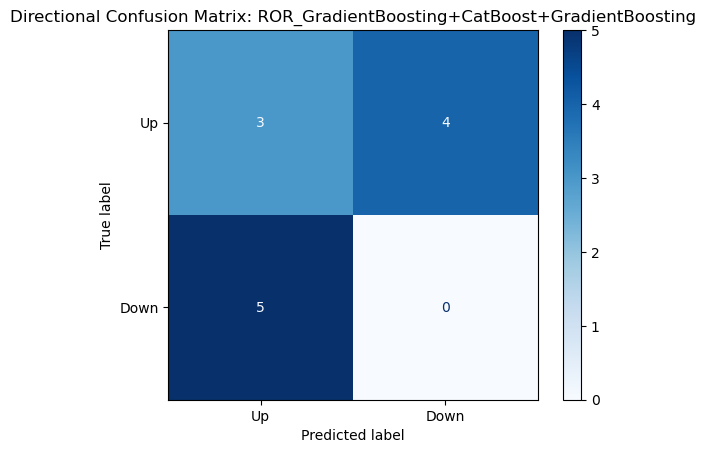

In [61]:
# 11. 최종 성능 비교 + 방향성 혼동행렬
print("=" * 70)
print("11. 최종 지표 비교 + 방향성 혼동행렬")
print("=" * 70)

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_metrics_with_adj_r2(y_true, y_pred, n_features):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    df = pd.concat([y_true, y_pred], axis=1).dropna()
    if len(df) == 0:
        return None
    yt = df.iloc[:, 0].values
    yp = df.iloc[:, 1].values
    n = len(yt)

    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mae = float(np.mean(np.abs(yt - yp)))

    eps = 1e-8
    denom = np.where(np.abs(yt) < eps, np.nan, np.abs(yt))
    ape = np.abs((yt - yp) / denom)
    spe = ((yt - yp) / denom) ** 2
    mape = float(np.nanmean(ape) * 100)
    rmspe = float(np.sqrt(np.nanmean(spe)) * 100)

    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    r2 = np.nan
    if ss_tot > 0:
        r2 = 1 - (ss_res / ss_tot)

    adj_r2 = np.nan
    if not np.isnan(r2) and n > (n_features + 1):
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

    return {
        'RMSE': rmse,
        'RMSPE': rmspe,
        'MAPE': mape,
        'MAE': mae,
        'Adj_R2': adj_r2,
        'N': n
    }

def directional_confusion(y_true, y_pred, prev_prices, threshold=0.0):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    prev_prices = pd.Series(prev_prices)
    df = pd.concat([y_true, y_pred, prev_prices], axis=1).dropna()
    if len(df) == 0:
        return None
    yt = df.iloc[:, 0].values
    yp = df.iloc[:, 1].values
    pv = df.iloc[:, 2].values

    actual_ret = (yt - pv) / pv
    pred_ret = (yp - pv) / pv

    y_true_dir = np.where(actual_ret > threshold, 1, np.where(actual_ret < -threshold, -1, 0))
    y_pred_dir = np.where(pred_ret > threshold, 1, np.where(pred_ret < -threshold, -1, 0))

    mask = (y_true_dir != 0) & (y_pred_dir != 0)
    if mask.sum() == 0:
        return None

    cm = confusion_matrix(y_true_dir[mask], y_pred_dir[mask], labels=[1, -1])
    up_hit, up_miss = cm[0, 0], cm[0, 1]
    down_miss, down_hit = cm[1, 0], cm[1, 1]
    acc = (up_hit + down_hit) / cm.sum() if cm.sum() else 0
    return cm, {
        'Up_Hit': int(up_hit),
        'Up_Miss': int(up_miss),
        'Down_Miss': int(down_miss),
        'Down_Hit': int(down_hit),
        'Directional_Acc': float(acc)
    }

# ------------------------------------------------------------
# 로드 DL (LSTM/Transformer) predictions if available
# ------------------------------------------------------------
dl_pred_path = os.path.join(OUTPUT_DIR, 'dl_predictions.csv')
if os.path.exists(dl_pred_path):
    dl_preds = pd.read_csv(dl_pred_path, index_col=0, parse_dates=True)
    for col in dl_preds.columns:
        if col == 'Actual':
            continue
        if col not in preds.columns:
            preds[col] = dl_preds[col].reindex(preds.index)
    print(f'Loaded DL predictions: {dl_pred_path}')
else:
    print('DL predictions not found. Run dl_lstm_transformer.ipynb to include LSTM/Transformer results.')


# ------------------------------------------------------------
# Naive 후속 실험 예측값 포함 확인
# ------------------------------------------------------------
naive_added = []
if 'preds' not in globals():
    preds = pd.DataFrame(index=y_test.index)

# Naive 베이스라인 계산
if 'Naive_Last' not in preds.columns or 'Naive_Drift' not in preds.columns:
    _series = price_full if 'price_full' in globals() else y
    _idx = y_test.index
    _prev = _series.shift(1).reindex(_idx).copy()
    _prev_prev = _series.shift(2).reindex(_idx).copy()
    _prior = _series.loc[_series.index < _idx[0]]
    if len(_prior) >= 2:
        _prev.iloc[0] = _prior.iloc[-1]
        _prev_prev.iloc[0] = _prior.iloc[-2]
    _naive_last = _prev
    _naive_drift = _prev + (_prev - _prev_prev)
    preds['Naive_Last'] = _naive_last
    preds['Naive_Drift'] = _naive_drift
    naive_added += ['Naive_Last', 'Naive_Drift']

# 단순이동평균(4주)
if 'Naive_SMA4' not in preds.columns:
    _series = price_full if 'price_full' in globals() else y
    _idx = y_test.index
    _sma4 = _series.rolling(4).mean().shift(1).reindex(_idx).copy()
    _prior = _series.loc[_series.index < _idx[0]]
    if len(_prior) >= 4:
        _sma4.iloc[0] = _prior.tail(4).mean()
    preds['Naive_SMA4'] = _sma4
    naive_added.append('Naive_SMA4')

# 감쇠 드리프트 변형
for _alpha in [0.3, 0.5, 0.7, 0.9]:
    _col = f'Naive_Drift_Damped_a{_alpha}'
    if _col not in preds.columns and 'Naive_Drift' in preds.columns:
        _series = price_full if 'price_full' in globals() else y
        _idx = y_test.index
        _prev = _series.shift(1).reindex(_idx).copy()
        _prev_prev = _series.shift(2).reindex(_idx).copy()
        _prior = _series.loc[_series.index < _idx[0]]
        if len(_prior) >= 2:
            _prev.iloc[0] = _prior.iloc[-1]
            _prev_prev.iloc[0] = _prior.iloc[-2]
        _drift = _prev - _prev_prev
        preds[_col] = _prev + _alpha * _drift
        naive_added.append(_col)

# 하이브리드 (ML 베이스라인 존재 시)
if 'BASE_GradientBoosting' in preds.columns and 'Naive_Drift' in preds.columns:
    _ml_pred = preds['BASE_GradientBoosting']
    for _w in [0.7, 0.8, 0.9]:
        _col = f'Hybrid_Naive{_w:.1f}_ML{1-_w:.1f}'
        if _col not in preds.columns:
            preds[_col] = _w * preds['Naive_Drift'] + (1 - _w) * _ml_pred
            naive_added.append(_col)

# Naive + ML 잔차/ROR 스태킹
if 'Naive_ML_Residual' not in preds.columns and 'stage2_pred' in globals():
    preds['Naive_ML_Residual'] = stage2_pred
    naive_added.append('Naive_ML_Residual')
    if 'resid_pred' in globals() and 'Naive_Drift' in preds.columns:
        for _d in [0.3, 0.5, 0.7]:
            _col = f'Naive_ML_Residual_Damped_{_d}'
            if _col not in preds.columns:
                preds[_col] = preds['Naive_Drift'] + _d * resid_pred
                naive_added.append(_col)

if 'Naive_ML_ROR' not in preds.columns and 'stage3_pred' in globals():
    preds['Naive_ML_ROR'] = stage3_pred
    naive_added.append('Naive_ML_ROR')
    if 'ror_pred' in globals() and 'stage2_pred' in globals():
        for _d in [0.1, 0.3, 0.5]:
            _col = f'Naive_ML_ROR_Damped_{_d}'
            if _col not in preds.columns:
                preds[_col] = stage2_pred + _d * ror_pred
                naive_added.append(_col)

if len(naive_added) > 0:
    print(f'Naive follow-up preds added: {naive_added}')

# ------------------------------------------------------------
# 최종 성능 비교
# ------------------------------------------------------------
n_features = len(selected_features) if 'selected_features' in globals() else X.shape[1]
metrics_rows = []
for model_name in preds.columns:
    if model_name == 'Actual':
        continue
    m = compute_metrics_with_adj_r2(y_test, preds[model_name], n_features)
    if m is None:
        continue
    m['Model'] = model_name
    metrics_rows.append(m)

final_metrics_df = pd.DataFrame(metrics_rows).set_index('Model')
final_metrics_df = final_metrics_df.sort_values('RMSE')

# 요청된 지표만 표시
display_cols = ['RMSE', 'RMSPE', 'MAPE', 'MAE', 'Adj_R2']
print('\n【최종 지표 비교】')
display(final_metrics_df[display_cols].style.format({
    'RMSE': '{:.4f}',
    'RMSPE': '{:.2f}',
    'MAPE': '{:.2f}',
    'MAE': '{:.4f}',
    'Adj_R2': '{:.4f}'
}))

# 저장 to output
final_metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'final_metrics_comparison.csv'))

# ------------------------------------------------------------
# 방향성 혼동행렬 (상승/하락)
# ------------------------------------------------------------
prev_prices_test = compute_prev_prices(price_full, y_test.index)
conf_rows = []
for model_name in final_metrics_df.index:
    result = directional_confusion(y_test, preds[model_name], prev_prices_test)
    if result is None:
        continue
    _, stats = result
    stats['Model'] = model_name
    conf_rows.append(stats)

conf_df = pd.DataFrame(conf_rows).set_index('Model')
print('\n【방향성 혼동행렬 요약】')
display(conf_df.sort_values('Directional_Acc', ascending=False))
conf_df.to_csv(os.path.join(OUTPUT_DIR, 'directional_confusion_summary.csv'))

# 최적 모델 혼동행렬 시각화
best_model = final_metrics_df.index[0] if len(final_metrics_df) > 0 else None
if 'selected_model_name' in globals() and selected_model_name in preds.columns:
    best_model = selected_model_name

if best_model is not None:
    cm_result = directional_confusion(y_test, preds[best_model], prev_prices_test)
    if cm_result is not None:
        cm, _ = cm_result
        disp = ConfusionMatrixDisplay(cm, display_labels=['Up', 'Down'])
        disp.plot(cmap='Blues')
        plt.title(f'Directional Confusion Matrix: {best_model}')
        plt.show()
    else:
        print('Not enough directional signals to plot confusion matrix.')